In [1]:
import numpy as np
import torch
import warnings
import shutil
import open_clip
#from open_clip import tokenizer
import time

import os, glob
import skimage
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import OrderedDict
import torch

import importlib
import CLIP_Module
import CLIP_GA
importlib.reload(CLIP_Module)
importlib.reload(CLIP_GA)

from CLIP_Module import *  # Re-import function to reflect updates
from CLIP_GA import *



%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Ignore all warnings
#warnings.filterwarnings("ignore")

#pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128

In [2]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Device name:", torch.cuda.get_device_name(device))

    # Print memory stats
    total_mem = torch.cuda.get_device_properties(device).total_memory / 1024**3  # in GB
    allocated = torch.cuda.memory_allocated(device) / 1024**3
    reserved = torch.cuda.memory_reserved(device) / 1024**3

    print(f"Total GPU memory : {total_mem:.2f} GB")
    print(f"Memory Allocated: {allocated:.2f} GB")
    print(f"Memory Reserved : {reserved:.2f} GB")
else:
    print("No GPU available.")


CUDA available: True
Device name: NVIDIA B200
Total GPU memory : 178.36 GB
Memory Allocated: 0.00 GB
Memory Reserved : 0.00 GB


# Load images

In [3]:
def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # If the value is not found

In [4]:
# Check if the file exists before reading
file_path = "Florida_Images_Folders02202025.txt"

if os.path.exists(file_path):
    with open(file_path, "r") as f:
        Florida_Images_Folders = [line.strip() for line in f]
    print("File loaded successfully.")
    
else:
    print(f"File '{file_path}' does not exist.")
    Florida_Images_Folders1 = glob.glob("/blue/changzhao/GeoAI-CES/Data/unzipdata/*/*.jpg") #entire US 2016~2021
    Florida_Images_Folders2 = glob.glob("/blue/changzhao/GeoAI-CES/Data/Raw_Flicker_Metadata/Flickr_US_2013_2016_Images/*/*.jpg") #entire US 2013~2016
    Florida_Images_Folders3 = glob.glob("/blue/changzhao/haoyuliao/CES/LabelState&DowoloadMissImgs/Missing_Images/*/*.jpg") #entire US 2012~2021
    Florida_Images_Folders4 = glob.glob("/blue/changzhao/haoyuliao/CES/LabelState&DowoloadMissImgs/HuntingDownload/*.jpg") #entire US 2012~2021
    Florida_Images_Folders5 = glob.glob("/blue/changzhao/haoyuliao/CES/LabelState&DowoloadMissImgs/IncreaseImgFromD5/*/*.jpg") #entire US 2012~2021


    Florida_Images_Folders = Florida_Images_Folders1.copy()  # To avoid modifying the original list1
    Florida_Images_Folders.extend(Florida_Images_Folders2)
    Florida_Images_Folders.extend(Florida_Images_Folders3)
    Florida_Images_Folders.extend(Florida_Images_Folders4)
    Florida_Images_Folders.extend(Florida_Images_Folders5)

    # Save the complete list to a text file
    with open("Florida_Images_Folders02202025.txt", "w") as f:
        for item in Florida_Images_Folders:
            f.write(f"{item}\n")

File loaded successfully.


In [5]:
metadata = pd.read_excel("Training&TestingDataset_06252025v3.xlsx")

In [6]:
photo_ids = [str(x) for x in metadata['id']]
images_paths_map = {x.split('/')[-1].split('_')[0]: x for x in Florida_Images_Folders}

In [7]:
metadata_other = metadata[metadata['label'] == 'Other'].reset_index(drop=True)
metadata_ces = metadata[metadata['label'] != 'Other'].reset_index(drop=True)

In [8]:
def getTrainingTesting(metadata, metadata_other, metadata_ces, s = 10):
    metadata_other_train_all = metadata_other.sample(n=720, random_state=42)
    metadata_other_train = metadata_other.sample(n=s*12, random_state=42) #select only 10
    metadata_other_test = metadata_other.drop(metadata_other_train_all.index).reset_index(drop=True)
    
    overlap_ids = set(metadata_other_train['id']) & set(metadata_other_test['id'])

#     # Print result
#     print(f"Number of overlapping IDs: {len(overlap_ids)}")
#     print("Overlapping IDs:", overlap_ids)
    
        #training
    training_dataset1 = metadata[(metadata['Phase'] == 'Training') & (metadata['label'] != 'Other')].reset_index(drop=True)
    training_dataset2 = metadata[(metadata['Phase'] == 'ModelComparsion') & (metadata['label'] != 'Other')].reset_index(drop=True)
    training_dataset = pd.concat([training_dataset1, training_dataset2], ignore_index=True)

    training_dataset = training_dataset.groupby('label').sample(n=s, random_state=42)
    training_dataset = pd.concat([training_dataset, metadata_other_train], ignore_index=True)
    training_dataset = training_dataset.drop_duplicates(subset='id').reset_index(drop=True)

    #testing
    testing_dataset = metadata[(metadata['Phase'] == 'Testing') & (metadata['label'] != 'Other')].reset_index(drop=True)
    testing_dataset = testing_dataset.drop_duplicates(subset='id').reset_index(drop=True)
    testing_dataset = pd.concat([testing_dataset, metadata_other_test], ignore_index=True)
    
    overlap_ids = set(training_dataset['id']) & set(testing_dataset['id'])

    if overlap_ids:
        print(f"Data leakage detected! {len(overlap_ids)} overlapping IDs:")
        print(overlap_ids)
    else:
        print("No data leakage: training and testing IDs are unique.")
        
    training_dataset['Binary_Label'] = 0 # Default to 0 (Other)
    training_dataset.loc[training_dataset['label'] != 'Other', 'Binary_Label'] = 1 # Set to 1 for CES

    testing_dataset['Binary_Label'] = 0
    testing_dataset.loc[testing_dataset['label'] != 'Other', 'Binary_Label'] = 1
        
    return training_dataset, testing_dataset
    
    

# Feature extractor

In [9]:
def CLIP_extractfeatures(images, model, tokenizer): #Clip operation.
    import psutil
    print('start')
    # Get the memory usage in bytes
    memory_usage = psutil.Process().memory_info().rss
    
    torch.cuda.empty_cache()  # Clear unused memory
    
    with torch.no_grad():
        image_input = torch.stack(images).to(device)

        # Start the timer
        start_time = time.perf_counter()


        image_features_storage = []
        for i in range(int(len(image_input)/1000)+1):
            sub_start_time = time.perf_counter()
            print(i)
            if i == int(len(image_input)/1000):
                image_subinput = image_input[i*1000:,:,:,:]     
            else:
                image_subinput = image_input[i*1000:1000+i*1000,:,:,:]

            with torch.no_grad():
                image_features = model.encode_image(image_subinput).float()
            image_features_storage.append(image_features)

            del image_features
            torch.cuda.empty_cache()  # Clear unused memory
            
            # Get the memory usage in bytes
            memory_usage = psutil.Process().memory_info().rss

            # Convert to megabytes
            memory_usage_mb = memory_usage / (1024 ** 2)
            print(f"Memory Usage: {memory_usage_mb:.2f} MB")
            
            # End the timer
            sub_end_time = time.perf_counter()
            # Calculate the time taken
            execution_time = sub_end_time - sub_start_time
            print(f"{i} Execution time: {execution_time:.6f} seconds")


        # End the timer
        end_time = time.perf_counter()
        # Calculate the time taken
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time:.6f} seconds")
        image_features_storage_cpu = [item.cpu() for sublist in image_features_storage for item in sublist]
        return np.array(image_features_storage_cpu)
    
def feature_storeImgs(promptHikingHash, preprocess, images_paths_map): #Store the images.
    original_images = []
    images = []
    images_class = []
    
    for k, v in promptHikingHash.items():
        idx = k.split("_")[0]
        image_path = images_paths_map.get(str(idx)) 
        if image_path:
            image = Image.open(image_path).convert("RGB")
            original_images.append(image)
            #images.append(preprocess(image).to(device))
            images.append(preprocess(image).to("cpu"))
            images_class.append(v)
    
    return images, np.array(images_class)

In [10]:
model_name = 'MobileCLIP-S1'  # Replace with your model
pretrained = 'datacompdr'      # Specify the pretrained source

model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)  # Correct tokenizer initialization

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval() ##Important to turn on.

save_dir = 'CLIP_RF_RunFL-Parameters'
os.makedirs(save_dir, exist_ok=True)

# Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.decomposition import PCA

## Simple TT

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

s = 5

training_dataset, testing_dataset = getTrainingTesting(metadata, metadata_other, metadata_ces, s = s)

train_ModelMetadata = {str(training_dataset['id'].iloc[x])+"_"+str(training_dataset['Phase'].iloc[x]): training_dataset['Binary_Label'].iloc[x] for x in range(len(training_dataset['id']))}     
train_imagesMetadata, train_imagesMetadata_label = feature_storeImgs(train_ModelMetadata, preprocess, images_paths_map)

test_ModelMetadata = {str(testing_dataset['id'].iloc[x])+"_"+str(testing_dataset['Phase'].iloc[x]): testing_dataset['Binary_Label'].iloc[x] for x in range(len(testing_dataset['id']))}     
test_imagesMetadata, test_imagesMetadata_label = feature_storeImgs(test_ModelMetadata, preprocess, images_paths_map)

No data leakage: training and testing IDs are unique.


In [16]:
training_dataset[['id']].to_excel('training_ids.xlsx', index=False)

In [13]:

train_image_features = CLIP_extractfeatures(train_imagesMetadata, model, tokenizer)
test_image_features = CLIP_extractfeatures(test_imagesMetadata, model, tokenizer)
# print(training_dataset['label'].value_counts())
# print(testing_dataset['label'].value_counts())

start
0
Memory Usage: 23025.33 MB
0 Execution time: 22.846896 seconds
Execution time: 22.846933 seconds
start
0
Memory Usage: 23026.98 MB
0 Execution time: 0.510372 seconds
1
Memory Usage: 23026.98 MB
1 Execution time: 0.477817 seconds
2
Memory Usage: 23026.98 MB
2 Execution time: 0.477040 seconds
3
Memory Usage: 23026.98 MB
3 Execution time: 0.477810 seconds
4
Memory Usage: 23026.98 MB
4 Execution time: 0.094425 seconds
Execution time: 2.037504 seconds


In [14]:
train_image_features.shape

(120, 512)

In [15]:
# Extract features and labels
X_train = train_image_features
y_train = training_dataset['Binary_Label']

X_test = test_image_features
y_test = testing_dataset['Binary_Label']


# pca = PCA(n_components=50)  # or explain 95% variance
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

param_grid = {
    'n_estimators': 200, 
    'max_depth': None,            # Control overfitting
    'min_samples_split': 2,            # Control splits, higher = more conservative
    'min_samples_leaf': 1,              # Prevent small leaf nodes
    'max_features': 'log2',      # None = all features (can overfit), sqrt/log2 are good
    'class_weight': "balanced",
}


# Initialize and train classifier
clf = RandomForestClassifier(**param_grid, random_state=42)
clf.fit(X_train, y_train)
#clf.fit(X_train_pca, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=200, random_state=42)

In [16]:
import joblib

joblib.dump(clf, "BRF_model.joblib")


['BRF_model.joblib']

In [20]:
clf1 = joblib.load("BRF_model.joblib")


In [21]:
# Predict
y_train_pred = clf1.predict(X_train)
y_test_pred = clf1.predict(X_test)
#y_pred = clf.predict(X_test)

# Evaluate
print('Train')
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print('Test')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Train
Confusion Matrix:
 [[60  0]
 [ 0 60]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Test
Confusion Matrix:
 [[ 688   32]
 [ 110 3355]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       720
           1       0.99      0.97      0.98      3465

    accuracy                           0.97      4185
   macro avg       0.93      0.96      0.94      4185
weighted avg       0.97      0.97      0.97      4185



In [17]:
# Predict
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
#y_pred = clf.predict(X_test)

# Evaluate
print('Train')
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print('Test')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Train
Confusion Matrix:
 [[60  0]
 [ 0 60]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Test
Confusion Matrix:
 [[ 688   32]
 [ 110 3355]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       720
           1       0.99      0.97      0.98      3465

    accuracy                           0.97      4185
   macro avg       0.93      0.96      0.94      4185
weighted avg       0.97      0.97      0.97      4185



In [21]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd

# # Create a stratified CV splitter
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


# param_grid = {
#     'n_estimators': [200], 
#     'max_depth': [None],            # Control overfitting
#     'min_samples_split': [2],            # Control splits, higher = more conservative
#     'min_samples_leaf': [1],              # Prevent small leaf nodes
#     'max_features': ['log2'],      # None = all features (can overfit), sqrt/log2 are good
#     'class_weight': ["balanced"]
# }

# # Start timer
# start_time = time.time()

# clf = RandomForestClassifier(random_state=42)

# # Use StratifiedKFold in GridSearchCV
# grid_search = GridSearchCV(
#     estimator=clf,
#     param_grid=param_grid,
#     scoring='accuracy',  # or 'f1_macro' if class balance matters
#     cv=skf,  # <- ensures stratified splits
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# print('Samples: ',s) 

# print("Best parameters:", grid_search.best_params_)

# # End timer
# elapsed_time = time.time() - start_time
# print(f"Total runtime: {elapsed_time:.2f} seconds")

In [22]:
# # Predict using best estimator
# best_clf = grid_search.best_estimator_

# # Training predictions and accuracy
# y_train_pred = best_clf.predict(X_train)
# train_accuracy = (y_train_pred == y_train).mean()

# # Testing predictions and accuracy
# y_test_pred = best_clf.predict(X_test)
# test_accuracy = (y_test_pred == y_test).mean()

# # Print results
# print("Best Parameters:", grid_search.best_params_)
# print(f"Training Accuracy: {train_accuracy:.4f}")
# print(f"Testing Accuracy:  {test_accuracy:.4f}")

In [23]:
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9661


In [24]:
training_dataset['Predict_binary'] = ['CES' if i == 1 else 'Other' for i in y_train_pred]
testing_dataset['Predict_binary'] = ['CES' if i == 1 else 'Other' for i in y_test_pred]

In [20]:
combined = pd.concat([training_dataset, testing_dataset], ignore_index=True)
combined.to_csv(f'{save_dir}/RF_CLIP_Predict_res_s_{s}.csv', index=False)

# Confusion Matrix

In [21]:
class_names = ["Biking", "Boating", "Camping", "Fishing", "Hiking", "Horseback_Riding", "Hunting", "Shelling", "Surfing", 
               "Swimming", "Wildlife_Viewing", "Landscape_Aesthetics", "Other"]


def plotCom(label, pred, colab, save_dir, SaveName = f"{''}-{''}-ModelComparsion4RecCNN", show=True): #Draw confusion matrix.
    os.makedirs(f'{save_dir}/PredRes/', exist_ok=True)
    
    #colab = np.unique(colab)
    cm_nor = confusion_matrix(label, pred, labels=colab, normalize='true')*100

    # Normalize the confusion matrix by row
    cm_normalized_int_array = np.round(cm_nor, 0).astype(int)
    cm_normalized_int_array_checking = np.round(cm_nor, 1)
    print(cm_normalized_int_array_checking)

    #fig, ax = plt.subplots()  # Use fig, ax to properly handle plot saving later
    fig, ax = plt.subplots(figsize=(7, 7))  # Set figure size (width=10, height=8)
    # Plot the normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_int_array, display_labels=colab)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    #plt.title("CLIP")
    plt.xticks(rotation=90)
    if show: plt.show()

    # Calculate the accuracy
    accuracy = accuracy_score(label, pred)
    disp.figure_.savefig(f"{save_dir}/PredRes/{SaveName}_NorConfusionNormMatrix_Acc_{accuracy:.2f}.png",dpi=300, bbox_inches='tight')


    #fig, ax = plt.subplots()  # Use fig, ax to properly handle plot saving later
    fig, ax = plt.subplots(figsize=(7, 7))  # Set figure size (width=10, height=8)
    # Plot the confusion matrix
    cm = confusion_matrix(label, pred, labels=colab)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=colab)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    #plt.title("CLIP")
    plt.xticks(rotation=90)
    if show: plt.show()
    disp.figure_.savefig(f"{save_dir}/PredRes/{SaveName}_ConfusionNormMatrix_Acc_{accuracy:.2f}.png",dpi=300, bbox_inches='tight')
    print(f"Accuracy: {accuracy*100:0.0f}")
    
    return cm, accuracy

def confusionMatrix(clip_pred_res, training_dataset, testing_dataset, class_names, savePath = f"{save_dir}/{'CLIP_Correct_Pred'}_results.csv", s=0):
    clip_pred_res['RF_Correct_Pred'] = clip_pred_res['Clip_Predictions']
    
    training_dataset['id'] = training_dataset['id'].astype(str)
    testing_dataset['id'] = testing_dataset['id'].astype(str)
    clip_pred_res['id'] = clip_pred_res['id'].astype(str)

    # Step 2: Merge clip predictions into training and testing datasets
    training_merged = training_dataset.merge(clip_pred_res[['id', 'Clip_Predictions']], on='id', how='left')
    testing_merged = testing_dataset.merge(clip_pred_res[['id', 'Clip_Predictions']], on='id', how='left')



    training_merged['RF_Correct_Pred'] = np.where(
        training_merged['Predict_binary'] == 'Other',
        'Other',
        training_merged['Clip_Predictions']
    )

    testing_merged['RF_Correct_Pred'] = np.where(
        testing_merged['Predict_binary'] == 'Other',
        'Other',
        testing_merged['Clip_Predictions']
    )
    
    training_merged['Phase'] = 'Training'
    testing_merged['Phase'] = 'Testing'
    
    combined = pd.concat([training_merged, testing_merged], ignore_index=True)
    combined.to_csv(f'{os.path.dirname(savePath)}/RF_CLIP_CorrectPredict_s_{s}.csv', index=False)
    
    DatasetsCom = {
        "trainingRes": training_merged, 
        "testingRes": testing_merged, 
    }
    
    tmpA = pd.DataFrame()
    for name, data in DatasetsCom.items():
        print(name)
        cm, accuracy = plotCom(data['label'], data['RF_Correct_Pred'], class_names, save_dir = save_dir, SaveName = f"{name}-{'RF_Correct_Pred_metric'}_s_{s}")
        HashRes = classification_metrics(class_names, cm, class_names)
        tmpB = hash2pandas(HashRes, name)
        tmpA = pd.concat([tmpA, tmpB], ignore_index=True)
        print(HashRes,"\n")

    tmpA.to_csv(savePath, index=False)

5
trainingRes
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.]
 [  0.  20.   0.   0.   0.   0.   0.   0.  60.   0.   0.  20.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]


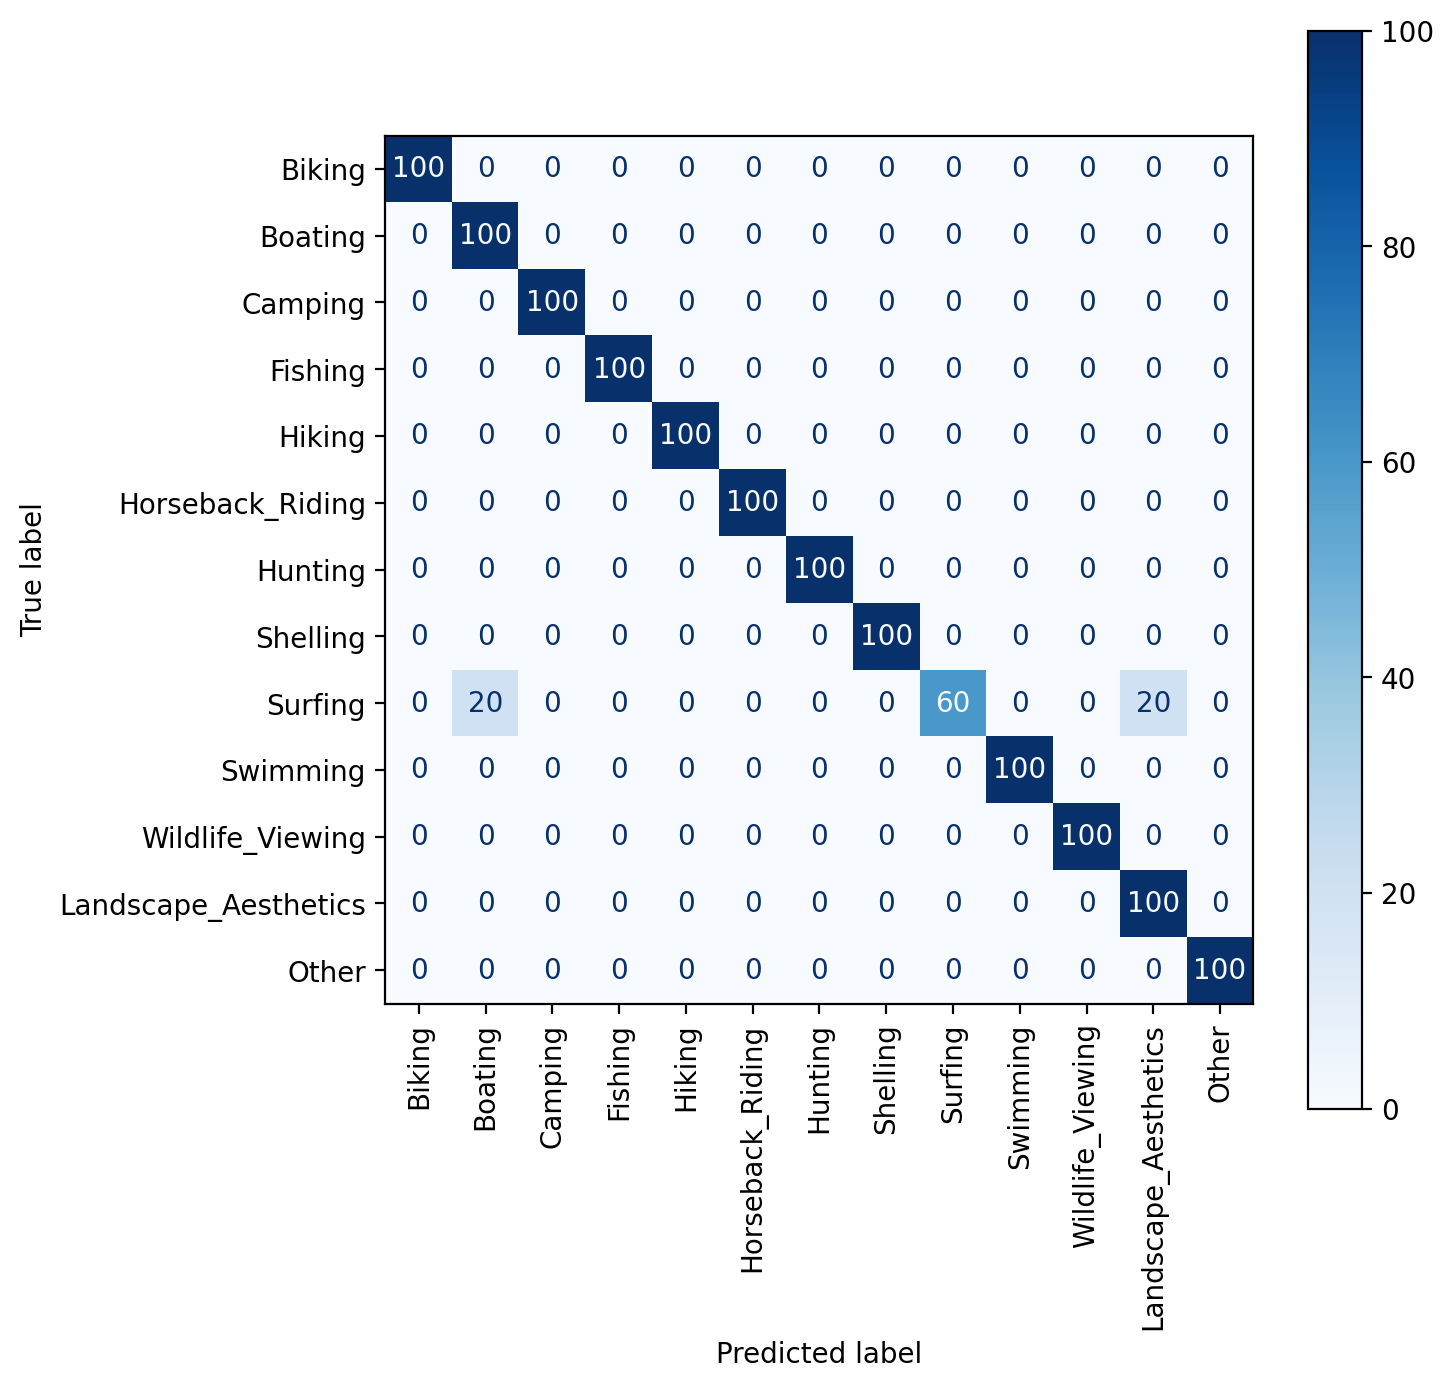

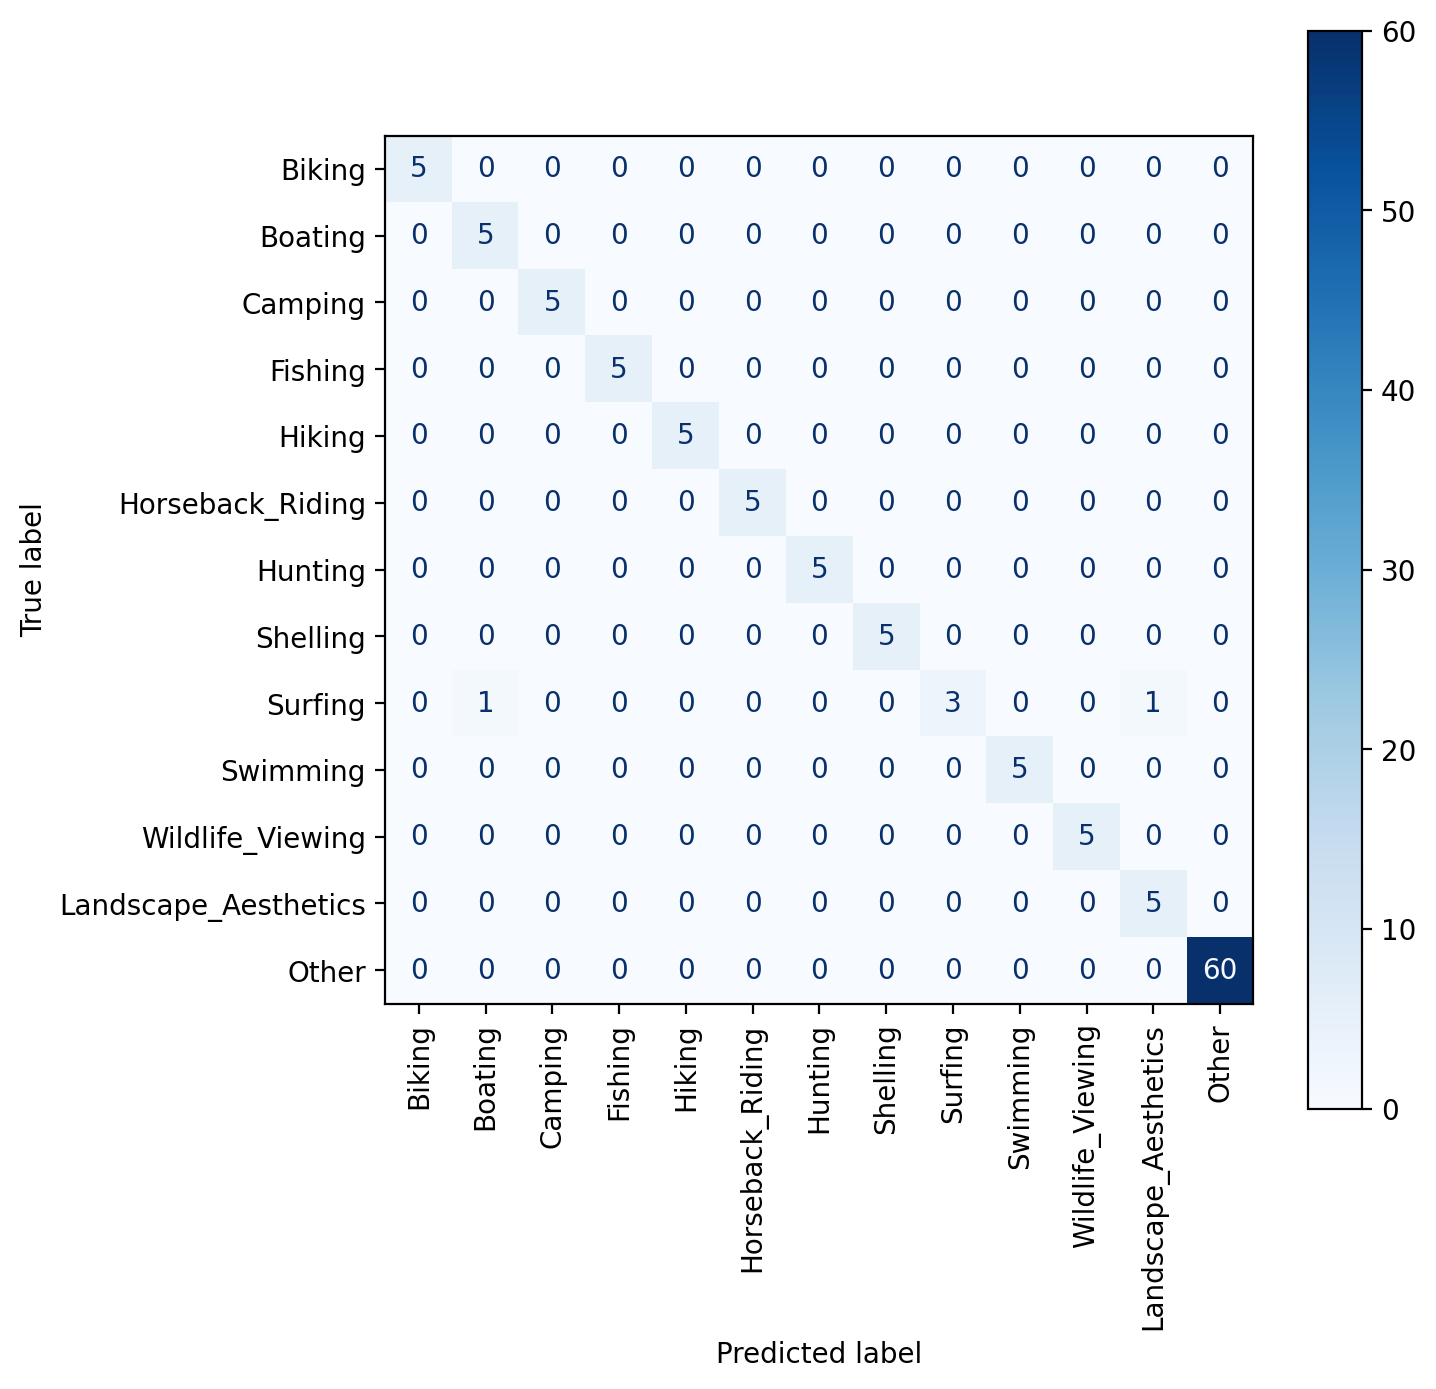

Accuracy: 98
Biking, Precision:100, Recall:100, F1:100
Boating, Precision:83, Recall:100, F1:91
Camping, Precision:100, Recall:100, F1:100
Fishing, Precision:100, Recall:100, F1:100
Hiking, Precision:100, Recall:100, F1:100
Horseback_Riding, Precision:100, Recall:100, F1:100
Hunting, Precision:100, Recall:100, F1:100
Shelling, Precision:100, Recall:100, F1:100
Surfing, Precision:100, Recall:60, F1:75
Swimming, Precision:100, Recall:100, F1:100
Wildlife_Viewing, Precision:100, Recall:100, F1:100
Landscape_Aesthetics, Precision:83, Recall:100, F1:91
Other, Precision:100, Recall:100, F1:100
Overall Acc:  98
Overall Precision:  97
Overall Recall:  97
Overall F1:  97
{'Biking': {'Description': 'Biking', 'Precision': 100, 'Recall': 100, 'F1-Score': 100}, 'Boating': {'Description': 'Boating', 'Precision': 83, 'Recall': 100, 'F1-Score': 91}, 'Camping': {'Description': 'Camping', 'Precision': 100, 'Recall': 100, 'F1-Score': 100}, 'Fishing': {'Description': 'Fishing', 'Precision': 100, 'Recall':

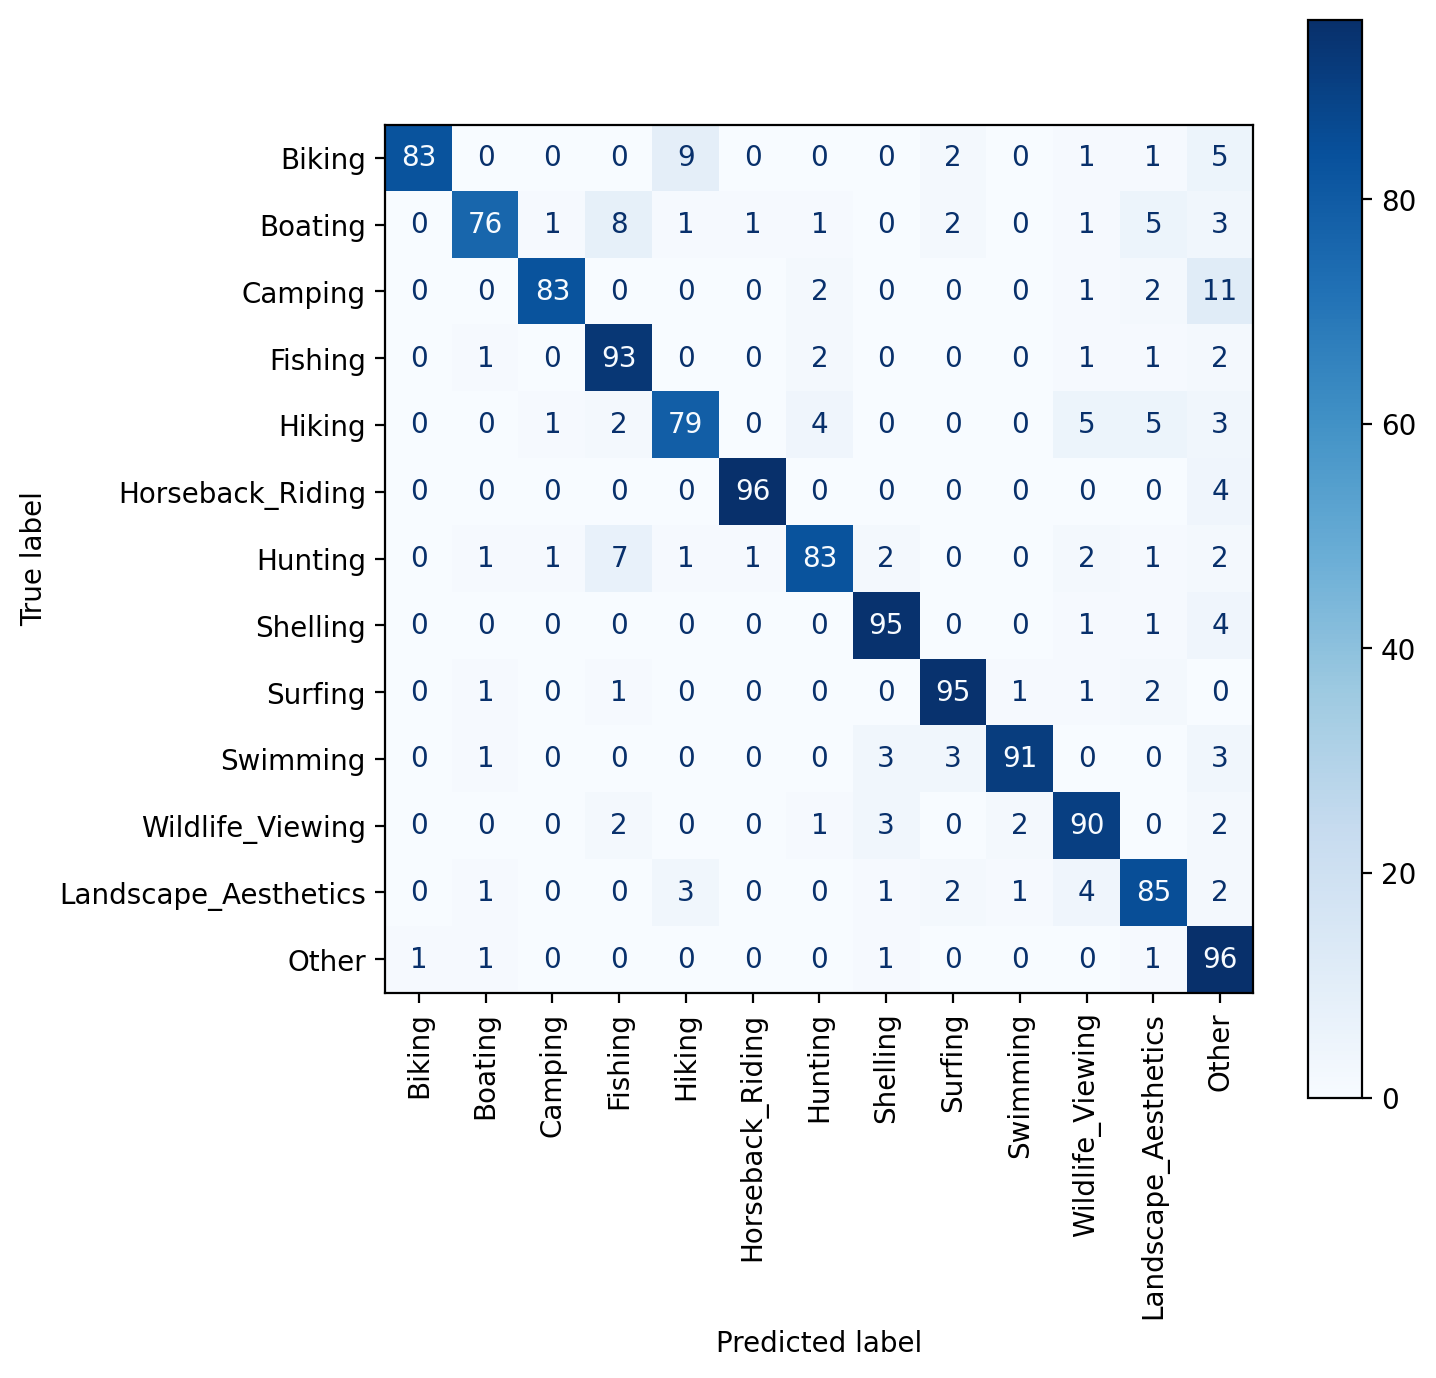

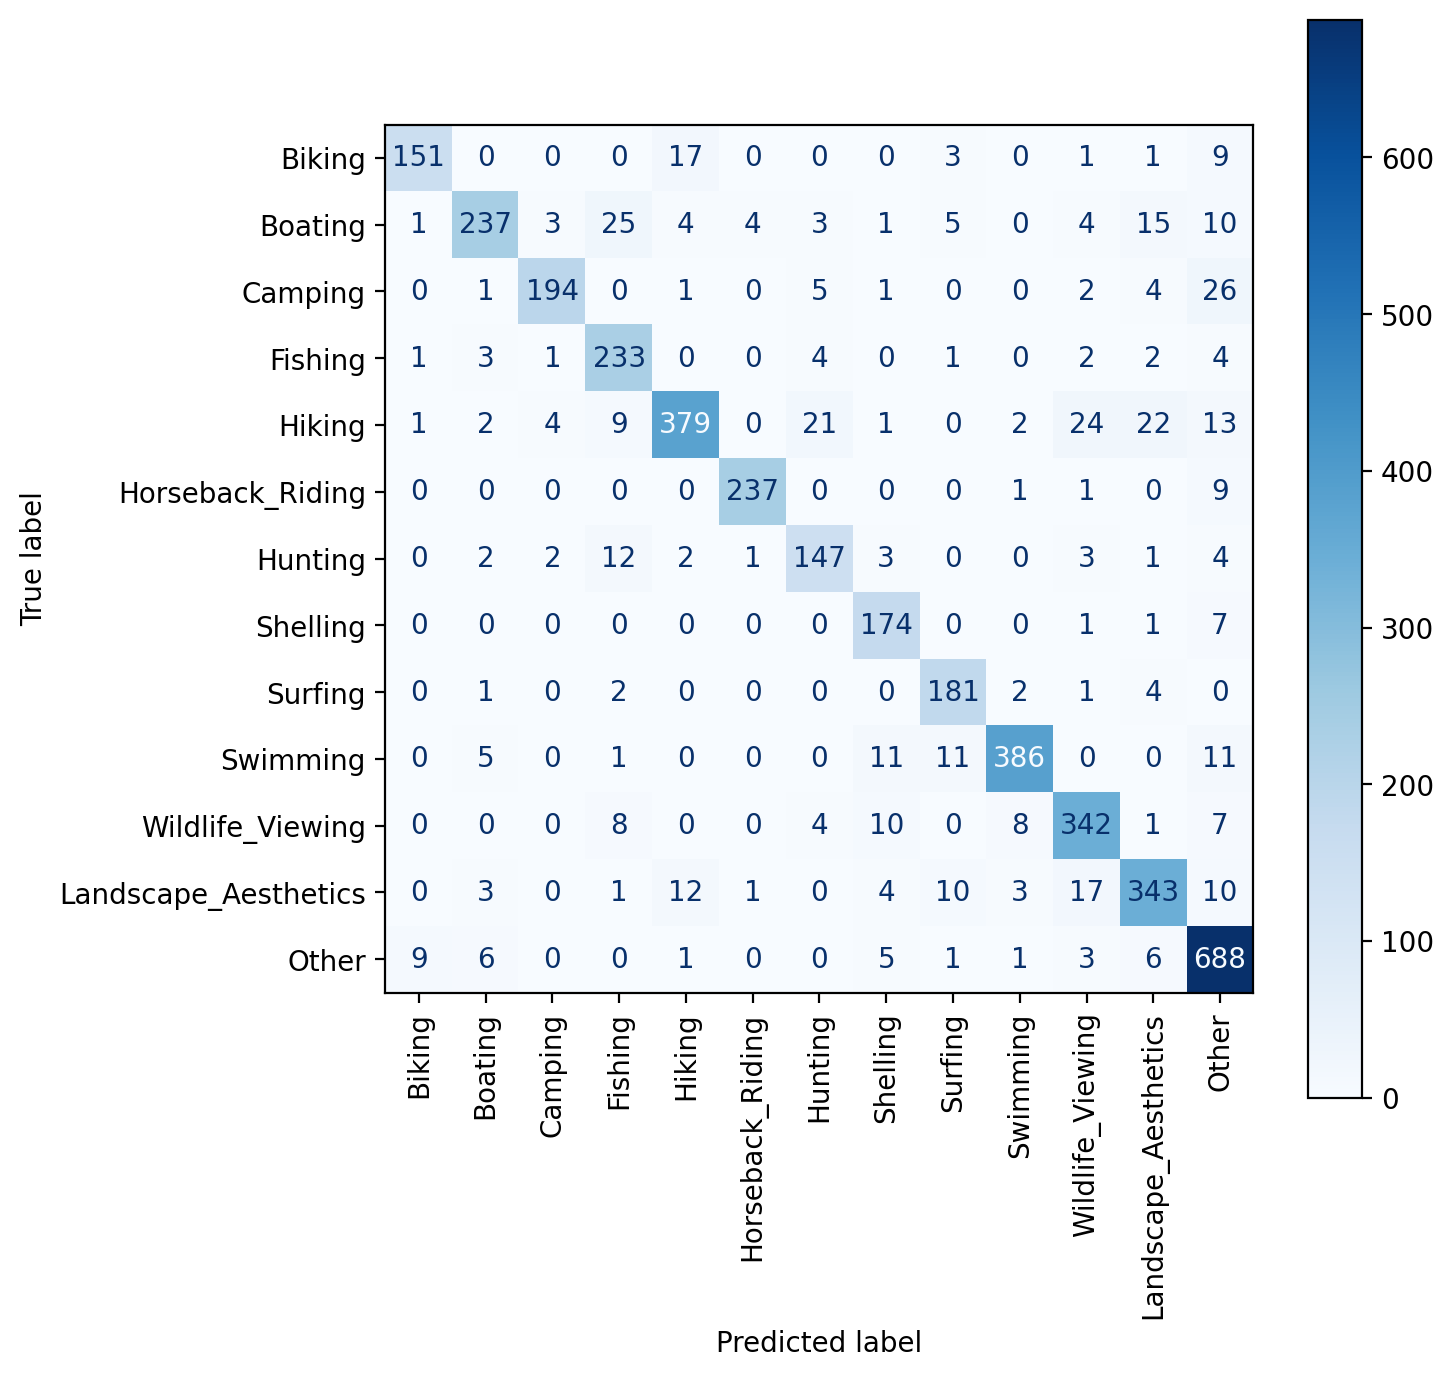

Accuracy: 88
Biking, Precision:93, Recall:83, F1:88
Boating, Precision:91, Recall:76, F1:83
Camping, Precision:95, Recall:83, F1:89
Fishing, Precision:80, Recall:93, F1:86
Hiking, Precision:91, Recall:79, F1:85
Horseback_Riding, Precision:98, Recall:96, F1:97
Hunting, Precision:80, Recall:83, F1:81
Shelling, Precision:83, Recall:95, F1:89
Surfing, Precision:85, Recall:95, F1:90
Swimming, Precision:96, Recall:91, F1:93
Wildlife_Viewing, Precision:85, Recall:90, F1:88
Landscape_Aesthetics, Precision:86, Recall:85, F1:85
Other, Precision:86, Recall:96, F1:91
Overall Acc:  88
Overall Precision:  88
Overall Recall:  88
Overall F1:  88
{'Biking': {'Description': 'Biking', 'Precision': 93, 'Recall': 83, 'F1-Score': 88}, 'Boating': {'Description': 'Boating', 'Precision': 91, 'Recall': 76, 'F1-Score': 83}, 'Camping': {'Description': 'Camping', 'Precision': 95, 'Recall': 83, 'F1-Score': 89}, 'Fishing': {'Description': 'Fishing', 'Precision': 80, 'Recall': 93, 'F1-Score': 86}, 'Hiking': {'Descrip

In [22]:
print(s)
clip_pred_res = pd.read_excel('BestPrompt_Predictions.xlsx').reset_index(drop=True)
confusionMatrix(clip_pred_res, training_dataset, testing_dataset, class_names, savePath = f"{save_dir}/{'CLIP_Correct_Pred'}_results_s_{s}.csv", s=5)

# Run FL

In [25]:
metadataFL = pd.read_csv("ALL_FL_Predictions_Thresholds_NLCD2023.csv")[400000:]
photo_ids = [str(x) for x in metadataFL['photoid']]
ModelMetadata = {str(metadataFL['photoid'].iloc[x])+"_FakeStr":'Fake' for x in range(len(metadataFL['photoid']))}     

/scratch/local/6432860/ipykernel_2178904/3007529333.py:1: DtypeWarning: Columns (14,139,140) have mixed types. Specify dtype option on import or set low_memory=False.
  metadataFL = pd.read_csv("ALL_FL_Predictions_Thresholds_NLCD2023.csv")[400000:]


In [26]:
len(metadataFL),metadataFL.columns

(274707,
 Index(['Unnamed: 0', 'photoid', 'ownerid', 'latitude', 'longitude',
        'uploaddate', 'takendate', 'tags', 'title', 'locaccuracy',
        ...
        'Min scores Predictions', 'Avg scores thr', 'Avg scores Predictions',
        'Fix18 scores thr', 'Fix18 scores Predictions', 'Fix20 scores thr',
        'Fix20 scores Predictions', 'NLCD_2023', 'lon', 'lat'],
       dtype='object', length=192))

In [27]:
# metadataFL = pd.read_csv("./CLIP_RF_RunFL/RF_CLIP_CorrectPredict_s_5.csv")
# photo_ids = [str(x) for x in metadataFL['id']]
# ModelMetadata = {str(metadataFL['id'].iloc[x])+"_FakeStr":'Fake' for x in range(len(metadataFL['id']))}

In [28]:
import psutil

y_pred = []
images = []
images_valid = [] #1 valid; 0: corruption
start_time = time.perf_counter()
n = 1

sub_start_time = time.perf_counter()
for idx in range(len(ModelMetadata)):
    try:
        image_path = images_paths_map[str(photo_ids[idx])]
        image = Image.open(image_path).convert("RGB")
        images_valid.append(1)
    except:
        image_path = images_paths_map[str(photo_ids[0])] #Fake Image
        image = Image.open(image_path).convert("RGB")
        images_valid.append(0)
    
    images.append(preprocess(image).to(device))
    
    if (idx+1)%500 == 0 or (idx+1) == len(ModelMetadata):
        image_input = torch.stack(images).to(device)
        with torch.no_grad():
            #image_features = model.encode_image(image_subinput[i]).float()
            image_features = model.encode_image(image_input).float()
            
        image_features_cpu = np.array(image_features.cpu())

        pred = clf.predict(image_features_cpu) #RF prediciton
        y_pred.append(pred)

        del image_input, image_features, images, image_features_cpu
        torch.cuda.empty_cache()  # Clear unused memory
        images = []
        
        # Get the memory usage in bytes
        memory_usage = psutil.Process().memory_info().rss

        # Convert to megabytes
        memory_usage_mb = memory_usage / (1024 ** 2)
        
        # End the timer
        sub_end_time = time.perf_counter()
        # Calculate the time taken
        sub_execution_time = sub_end_time - sub_start_time
        sub_start_time = time.perf_counter()
        print(f"{n} Execution time: {sub_execution_time:.6f} seconds")
        print(f"Memory Usage: {memory_usage_mb:.2f} MB")
        n+=1

/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


1 Execution time: 6.224371 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


2 Execution time: 5.736741 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


3 Execution time: 5.464768 seconds
Memory Usage: 24256.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


4 Execution time: 5.724736 seconds
Memory Usage: 24256.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


5 Execution time: 5.671382 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


6 Execution time: 5.468748 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


7 Execution time: 6.922898 seconds
Memory Usage: 24258.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


8 Execution time: 5.341193 seconds
Memory Usage: 24258.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


9 Execution time: 5.666797 seconds
Memory Usage: 24258.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


10 Execution time: 5.202476 seconds
Memory Usage: 24258.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


11 Execution time: 5.827476 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


12 Execution time: 5.506468 seconds
Memory Usage: 24257.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


13 Execution time: 5.476707 seconds
Memory Usage: 24256.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


14 Execution time: 5.449259 seconds
Memory Usage: 24256.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


15 Execution time: 5.475101 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


16 Execution time: 5.301947 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


17 Execution time: 5.440842 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


18 Execution time: 5.465930 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


19 Execution time: 5.545645 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


20 Execution time: 5.748304 seconds
Memory Usage: 24256.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


21 Execution time: 5.851577 seconds
Memory Usage: 24255.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


22 Execution time: 5.847653 seconds
Memory Usage: 24254.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


23 Execution time: 5.805161 seconds
Memory Usage: 24255.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


24 Execution time: 10.842877 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


25 Execution time: 5.333397 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


26 Execution time: 5.661909 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


27 Execution time: 5.958603 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


28 Execution time: 5.427574 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


29 Execution time: 5.657773 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


30 Execution time: 5.619526 seconds
Memory Usage: 24269.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


31 Execution time: 6.442724 seconds
Memory Usage: 24269.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


32 Execution time: 6.779732 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


33 Execution time: 5.261456 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


34 Execution time: 5.306554 seconds
Memory Usage: 24268.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


35 Execution time: 5.426746 seconds
Memory Usage: 24269.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


36 Execution time: 5.310617 seconds
Memory Usage: 24269.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


37 Execution time: 5.519474 seconds
Memory Usage: 24269.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


38 Execution time: 15.280756 seconds
Memory Usage: 24272.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


39 Execution time: 39.226231 seconds
Memory Usage: 24274.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


40 Execution time: 40.819826 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


41 Execution time: 44.365558 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


42 Execution time: 48.577454 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


43 Execution time: 46.806759 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


44 Execution time: 43.051783 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


45 Execution time: 40.104431 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


46 Execution time: 41.342892 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


47 Execution time: 41.949868 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


48 Execution time: 41.948796 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


49 Execution time: 40.513547 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


50 Execution time: 39.865295 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


51 Execution time: 37.983443 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


52 Execution time: 38.967983 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


53 Execution time: 39.221104 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


54 Execution time: 36.183809 seconds
Memory Usage: 24292.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


55 Execution time: 39.354963 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


56 Execution time: 35.633440 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


57 Execution time: 40.229648 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


58 Execution time: 9.789494 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


59 Execution time: 5.623217 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


60 Execution time: 6.175407 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


61 Execution time: 5.596448 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


62 Execution time: 5.754250 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


63 Execution time: 5.861681 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


64 Execution time: 5.337798 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


65 Execution time: 5.549566 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


66 Execution time: 5.619675 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


67 Execution time: 5.648697 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


68 Execution time: 5.751008 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


69 Execution time: 5.991520 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


70 Execution time: 5.460692 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


71 Execution time: 5.853272 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


72 Execution time: 5.260457 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


73 Execution time: 6.085190 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


74 Execution time: 6.038027 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


75 Execution time: 5.771830 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


76 Execution time: 6.058705 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


77 Execution time: 5.566298 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


78 Execution time: 5.445173 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


79 Execution time: 5.847986 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


80 Execution time: 5.237348 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


81 Execution time: 5.498429 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


82 Execution time: 5.617454 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


83 Execution time: 5.782083 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


84 Execution time: 5.552935 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


85 Execution time: 5.846247 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


86 Execution time: 5.935076 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


87 Execution time: 5.765663 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


88 Execution time: 5.566915 seconds
Memory Usage: 24291.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


89 Execution time: 5.938516 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


90 Execution time: 5.601201 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


91 Execution time: 5.892881 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


92 Execution time: 5.763895 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


93 Execution time: 5.742756 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


94 Execution time: 5.369724 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


95 Execution time: 5.750397 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


96 Execution time: 5.664717 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


97 Execution time: 5.994617 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


98 Execution time: 5.630111 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


99 Execution time: 6.209725 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


100 Execution time: 5.513405 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


101 Execution time: 5.674507 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


102 Execution time: 5.384863 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


103 Execution time: 5.780770 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


104 Execution time: 5.534536 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


105 Execution time: 5.551947 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


106 Execution time: 5.519791 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


107 Execution time: 5.838995 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


108 Execution time: 6.086676 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


109 Execution time: 5.417266 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


110 Execution time: 5.525762 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


111 Execution time: 5.682729 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


112 Execution time: 5.232786 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


113 Execution time: 5.560464 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


114 Execution time: 5.466570 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


115 Execution time: 5.445806 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


116 Execution time: 5.478137 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


117 Execution time: 6.068399 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


118 Execution time: 5.595717 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


119 Execution time: 5.341650 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


120 Execution time: 5.394190 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


121 Execution time: 5.924691 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


122 Execution time: 5.488184 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


123 Execution time: 5.651301 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


124 Execution time: 5.580851 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


125 Execution time: 5.563523 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


126 Execution time: 5.345440 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


127 Execution time: 6.077819 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


128 Execution time: 5.064997 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


129 Execution time: 5.448789 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


130 Execution time: 5.381318 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


131 Execution time: 5.415609 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


132 Execution time: 5.490684 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


133 Execution time: 5.326333 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


134 Execution time: 5.529246 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


135 Execution time: 5.954933 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


136 Execution time: 5.871942 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


137 Execution time: 5.821305 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


138 Execution time: 5.566271 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


139 Execution time: 5.387565 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


140 Execution time: 5.547697 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


141 Execution time: 5.501907 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


142 Execution time: 5.588763 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


143 Execution time: 5.584753 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


144 Execution time: 5.624026 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


145 Execution time: 6.910481 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


146 Execution time: 6.447113 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


147 Execution time: 6.112173 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


148 Execution time: 5.883211 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


149 Execution time: 5.749544 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


150 Execution time: 5.565931 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


151 Execution time: 6.035419 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


152 Execution time: 5.431074 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


153 Execution time: 5.485294 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


154 Execution time: 5.140596 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


155 Execution time: 5.504294 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


156 Execution time: 5.533555 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


157 Execution time: 5.412672 seconds
Memory Usage: 24291.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


158 Execution time: 5.551323 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


159 Execution time: 5.681579 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


160 Execution time: 6.301631 seconds
Memory Usage: 24290.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


161 Execution time: 5.915077 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


162 Execution time: 5.577881 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


163 Execution time: 5.825707 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


164 Execution time: 5.457665 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


165 Execution time: 5.634809 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


166 Execution time: 5.481134 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


167 Execution time: 5.451449 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


168 Execution time: 5.347137 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


169 Execution time: 5.148344 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


170 Execution time: 5.446503 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


171 Execution time: 5.262858 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


172 Execution time: 6.023476 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


173 Execution time: 5.687908 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


174 Execution time: 5.816556 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


175 Execution time: 5.960426 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


176 Execution time: 5.184052 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


177 Execution time: 5.543747 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


178 Execution time: 5.521441 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


179 Execution time: 5.806948 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


180 Execution time: 5.418608 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


181 Execution time: 5.812018 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


182 Execution time: 5.495964 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


183 Execution time: 5.646396 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


184 Execution time: 5.482380 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


185 Execution time: 6.117249 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


186 Execution time: 5.312502 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


187 Execution time: 5.625770 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


188 Execution time: 5.519292 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


189 Execution time: 5.568955 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


190 Execution time: 5.410797 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


191 Execution time: 5.486706 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


192 Execution time: 5.705501 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


193 Execution time: 5.556969 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


194 Execution time: 5.294980 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


195 Execution time: 5.669292 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


196 Execution time: 5.478461 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


197 Execution time: 5.560661 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


198 Execution time: 5.413366 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


199 Execution time: 5.662784 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


200 Execution time: 5.470001 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


201 Execution time: 5.945220 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


202 Execution time: 5.269929 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


203 Execution time: 5.624165 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


204 Execution time: 5.590211 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


205 Execution time: 5.475601 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


206 Execution time: 5.570114 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


207 Execution time: 5.461910 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


208 Execution time: 5.353423 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


209 Execution time: 5.200799 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


210 Execution time: 5.537509 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


211 Execution time: 5.315779 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


212 Execution time: 5.228102 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


213 Execution time: 5.034464 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


214 Execution time: 5.285690 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


215 Execution time: 5.527394 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


216 Execution time: 5.254544 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


217 Execution time: 5.051516 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


218 Execution time: 5.485074 seconds
Memory Usage: 24287.55 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


219 Execution time: 5.193927 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


220 Execution time: 5.187506 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


221 Execution time: 5.395444 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


222 Execution time: 6.871717 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


223 Execution time: 6.082213 seconds
Memory Usage: 24288.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


224 Execution time: 5.837233 seconds
Memory Usage: 24289.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


225 Execution time: 5.577517 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


226 Execution time: 6.175385 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


227 Execution time: 5.307221 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


228 Execution time: 5.358223 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


229 Execution time: 5.838347 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


230 Execution time: 5.711819 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


231 Execution time: 5.672115 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


232 Execution time: 5.710040 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


233 Execution time: 5.530931 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


234 Execution time: 6.123893 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


235 Execution time: 5.301769 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


236 Execution time: 6.043090 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


237 Execution time: 5.264447 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


238 Execution time: 5.856670 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


239 Execution time: 5.597267 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


240 Execution time: 5.753815 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


241 Execution time: 5.555678 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


242 Execution time: 6.025573 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


243 Execution time: 5.629169 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


244 Execution time: 5.563345 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


245 Execution time: 5.192273 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


246 Execution time: 5.632157 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


247 Execution time: 5.658902 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


248 Execution time: 5.557415 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


249 Execution time: 5.405378 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


250 Execution time: 5.485822 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


251 Execution time: 5.454092 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


252 Execution time: 5.400596 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


253 Execution time: 5.285799 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


254 Execution time: 5.342918 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


255 Execution time: 5.254980 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


256 Execution time: 5.367980 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


257 Execution time: 5.368796 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


258 Execution time: 5.122871 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


259 Execution time: 5.142550 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


260 Execution time: 5.479265 seconds
Memory Usage: 24281.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


261 Execution time: 5.408205 seconds
Memory Usage: 24281.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


262 Execution time: 5.462524 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


263 Execution time: 5.331483 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


264 Execution time: 5.596709 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


265 Execution time: 5.354288 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


266 Execution time: 5.780606 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


267 Execution time: 5.921571 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


268 Execution time: 5.522341 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


269 Execution time: 5.160866 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


270 Execution time: 5.948508 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


271 Execution time: 5.314578 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


272 Execution time: 5.465450 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


273 Execution time: 5.450472 seconds
Memory Usage: 24282.30 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


274 Execution time: 5.574582 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


275 Execution time: 5.403276 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


276 Execution time: 5.596917 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


277 Execution time: 5.205141 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


278 Execution time: 5.300400 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


279 Execution time: 5.199740 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


280 Execution time: 5.373531 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


281 Execution time: 5.669967 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


282 Execution time: 5.450423 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


283 Execution time: 5.670777 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


284 Execution time: 5.259760 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


285 Execution time: 5.606709 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


286 Execution time: 6.643446 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


287 Execution time: 11.249181 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


288 Execution time: 5.432080 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


289 Execution time: 5.211633 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


290 Execution time: 5.246578 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


291 Execution time: 5.309703 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


292 Execution time: 5.281023 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


293 Execution time: 5.998933 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


294 Execution time: 5.526511 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


295 Execution time: 5.606827 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


296 Execution time: 5.360507 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


297 Execution time: 5.505874 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


298 Execution time: 5.371327 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


299 Execution time: 5.140568 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


300 Execution time: 5.371727 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


301 Execution time: 5.630523 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


302 Execution time: 5.454176 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


303 Execution time: 5.414166 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


304 Execution time: 5.238792 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


305 Execution time: 5.328512 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


306 Execution time: 5.449369 seconds
Memory Usage: 24283.18 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


307 Execution time: 5.381495 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


308 Execution time: 6.348677 seconds
Memory Usage: 24284.05 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


309 Execution time: 5.657887 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


310 Execution time: 5.384115 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


311 Execution time: 3.928913 seconds
Memory Usage: 24284.93 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


312 Execution time: 4.415246 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


313 Execution time: 4.858576 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


314 Execution time: 5.619580 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


315 Execution time: 5.479657 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


316 Execution time: 5.585776 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


317 Execution time: 5.380284 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


318 Execution time: 5.409177 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


319 Execution time: 5.576412 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


320 Execution time: 6.014859 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


321 Execution time: 5.693197 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


322 Execution time: 5.879902 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


323 Execution time: 5.574164 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


324 Execution time: 5.448352 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


325 Execution time: 5.384671 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


326 Execution time: 5.750131 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


327 Execution time: 5.393701 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


328 Execution time: 5.322497 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


329 Execution time: 5.242056 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


330 Execution time: 5.620302 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


331 Execution time: 5.444723 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


332 Execution time: 5.470415 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


333 Execution time: 5.340846 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


334 Execution time: 5.231200 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


335 Execution time: 5.468926 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


336 Execution time: 4.803029 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


337 Execution time: 5.058395 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


338 Execution time: 5.298345 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


339 Execution time: 5.290927 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


340 Execution time: 5.324685 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


341 Execution time: 5.241469 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


342 Execution time: 5.311356 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


343 Execution time: 5.412547 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


344 Execution time: 5.274901 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


345 Execution time: 4.896597 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


346 Execution time: 5.309051 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


347 Execution time: 5.335402 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


348 Execution time: 5.131464 seconds
Memory Usage: 24286.68 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


349 Execution time: 5.858158 seconds
Memory Usage: 24285.80 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


350 Execution time: 5.193763 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


351 Execution time: 5.565839 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


352 Execution time: 5.302816 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


353 Execution time: 5.531575 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


354 Execution time: 6.261028 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


355 Execution time: 5.531595 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


356 Execution time: 5.453995 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


357 Execution time: 5.818603 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


358 Execution time: 5.473214 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


359 Execution time: 5.669647 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


360 Execution time: 5.527162 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


361 Execution time: 5.750422 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


362 Execution time: 5.356023 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


363 Execution time: 5.517896 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


364 Execution time: 5.576696 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


365 Execution time: 5.499361 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


366 Execution time: 5.191631 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


367 Execution time: 5.420092 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


368 Execution time: 5.319889 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


369 Execution time: 5.520521 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


370 Execution time: 5.340879 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


371 Execution time: 5.522849 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


372 Execution time: 5.410709 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


373 Execution time: 5.518334 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


374 Execution time: 5.250255 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


375 Execution time: 5.377812 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


376 Execution time: 5.728086 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


377 Execution time: 5.567832 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


378 Execution time: 5.196121 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


379 Execution time: 5.568277 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


380 Execution time: 5.285251 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


381 Execution time: 5.565974 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


382 Execution time: 5.358862 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


383 Execution time: 5.659711 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


384 Execution time: 5.113287 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


385 Execution time: 5.492351 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


386 Execution time: 5.290783 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


387 Execution time: 5.333744 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


388 Execution time: 5.753740 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


389 Execution time: 5.312216 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


390 Execution time: 5.727963 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


391 Execution time: 5.461550 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


392 Execution time: 5.577874 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


393 Execution time: 5.196045 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


394 Execution time: 5.576090 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


395 Execution time: 5.145686 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


396 Execution time: 5.382717 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


397 Execution time: 5.068980 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


398 Execution time: 5.518009 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


399 Execution time: 5.306295 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


400 Execution time: 5.417397 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


401 Execution time: 5.395870 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


402 Execution time: 5.432505 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


403 Execution time: 5.367904 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


404 Execution time: 5.475633 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


405 Execution time: 5.011110 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


406 Execution time: 5.460047 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


407 Execution time: 5.348545 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


408 Execution time: 5.429567 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


409 Execution time: 5.454666 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


410 Execution time: 5.184117 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


411 Execution time: 5.216398 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


412 Execution time: 5.236950 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


413 Execution time: 5.148456 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


414 Execution time: 5.321410 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


415 Execution time: 5.476337 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


416 Execution time: 5.577769 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


417 Execution time: 5.428094 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


418 Execution time: 5.442756 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


419 Execution time: 5.309460 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


420 Execution time: 5.377688 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


421 Execution time: 5.789497 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


422 Execution time: 5.481445 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


423 Execution time: 5.390239 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


424 Execution time: 5.705086 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


425 Execution time: 5.521976 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


426 Execution time: 5.475396 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


427 Execution time: 5.445255 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


428 Execution time: 5.794235 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


429 Execution time: 5.673702 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


430 Execution time: 5.544295 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


431 Execution time: 5.466302 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


432 Execution time: 5.769533 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


433 Execution time: 5.334566 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


434 Execution time: 5.291728 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


435 Execution time: 5.644906 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


436 Execution time: 5.548756 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


437 Execution time: 5.618342 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


438 Execution time: 5.597448 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


439 Execution time: 5.695344 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


440 Execution time: 5.743645 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


441 Execution time: 6.114828 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


442 Execution time: 5.700911 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


443 Execution time: 5.557558 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


444 Execution time: 6.962929 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


445 Execution time: 5.517036 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


446 Execution time: 5.674906 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


447 Execution time: 5.600451 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


448 Execution time: 5.273331 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


449 Execution time: 5.553654 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


450 Execution time: 5.634416 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


451 Execution time: 5.433572 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


452 Execution time: 6.006088 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


453 Execution time: 5.637938 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


454 Execution time: 5.344139 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


455 Execution time: 5.836900 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


456 Execution time: 5.413319 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


457 Execution time: 5.535516 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


458 Execution time: 5.261054 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


459 Execution time: 5.489957 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


460 Execution time: 5.326642 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


461 Execution time: 5.602134 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


462 Execution time: 5.452417 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


463 Execution time: 5.404630 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


464 Execution time: 5.734627 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


465 Execution time: 5.693164 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


466 Execution time: 5.712778 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


467 Execution time: 5.722219 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


468 Execution time: 5.777695 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


469 Execution time: 5.459277 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


470 Execution time: 5.420996 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


471 Execution time: 5.241516 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


472 Execution time: 5.951992 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


473 Execution time: 5.582125 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


474 Execution time: 5.984780 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


475 Execution time: 5.485659 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


476 Execution time: 5.675501 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


477 Execution time: 5.464770 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


478 Execution time: 5.638400 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


479 Execution time: 5.668334 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


480 Execution time: 5.561352 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


481 Execution time: 5.347973 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


482 Execution time: 5.732497 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


483 Execution time: 5.614100 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


484 Execution time: 5.444992 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


485 Execution time: 5.341646 seconds
Memory Usage: 24286.38 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


486 Execution time: 5.664624 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


487 Execution time: 5.536467 seconds
Memory Usage: 24285.50 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


488 Execution time: 5.763976 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


489 Execution time: 5.833152 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


490 Execution time: 5.777600 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


491 Execution time: 5.746971 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


492 Execution time: 6.028334 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


493 Execution time: 5.908003 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


494 Execution time: 6.092243 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


495 Execution time: 5.577234 seconds
Memory Usage: 24284.62 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


496 Execution time: 5.825372 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


497 Execution time: 5.535932 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


498 Execution time: 5.750509 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


499 Execution time: 5.759395 seconds
Memory Usage: 24283.75 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


500 Execution time: 5.707347 seconds
Memory Usage: 24282.88 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


501 Execution time: 5.951936 seconds
Memory Usage: 24282.88 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


502 Execution time: 5.494429 seconds
Memory Usage: 24282.00 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


503 Execution time: 5.117157 seconds
Memory Usage: 24282.00 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


504 Execution time: 5.203871 seconds
Memory Usage: 24282.00 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


505 Execution time: 5.349261 seconds
Memory Usage: 24281.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


506 Execution time: 5.565270 seconds
Memory Usage: 24281.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


507 Execution time: 5.842731 seconds
Memory Usage: 24281.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


508 Execution time: 5.213785 seconds
Memory Usage: 24281.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


509 Execution time: 5.110213 seconds
Memory Usage: 24281.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


510 Execution time: 5.563450 seconds
Memory Usage: 24275.00 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


511 Execution time: 5.528364 seconds
Memory Usage: 24275.88 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


512 Execution time: 6.357866 seconds
Memory Usage: 24275.88 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


513 Execution time: 6.168612 seconds
Memory Usage: 24274.08 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


514 Execution time: 5.866491 seconds
Memory Usage: 24268.03 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


515 Execution time: 5.475551 seconds
Memory Usage: 24267.16 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


516 Execution time: 5.521624 seconds
Memory Usage: 24266.28 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


517 Execution time: 5.449243 seconds
Memory Usage: 24150.67 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


518 Execution time: 5.895509 seconds
Memory Usage: 24149.79 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


519 Execution time: 5.886476 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


520 Execution time: 5.338781 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


521 Execution time: 5.433546 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


522 Execution time: 5.342841 seconds
Memory Usage: 24148.61 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


523 Execution time: 5.259127 seconds
Memory Usage: 24148.61 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


524 Execution time: 5.297260 seconds
Memory Usage: 24147.73 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


525 Execution time: 5.463150 seconds
Memory Usage: 24147.73 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


526 Execution time: 5.198419 seconds
Memory Usage: 24147.73 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


527 Execution time: 5.096562 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


528 Execution time: 5.077901 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


529 Execution time: 5.482128 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


530 Execution time: 5.364532 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


531 Execution time: 5.404821 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


532 Execution time: 5.067203 seconds
Memory Usage: 24146.86 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


533 Execution time: 5.178242 seconds
Memory Usage: 24143.36 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


534 Execution time: 5.751123 seconds
Memory Usage: 24143.36 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


535 Execution time: 5.413791 seconds
Memory Usage: 24142.43 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


536 Execution time: 5.313859 seconds
Memory Usage: 24129.52 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


537 Execution time: 5.407778 seconds
Memory Usage: 24126.02 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


538 Execution time: 5.070021 seconds
Memory Usage: 24120.77 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


539 Execution time: 5.662364 seconds
Memory Usage: 24120.77 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


540 Execution time: 5.779405 seconds
Memory Usage: 24119.77 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


541 Execution time: 5.654789 seconds
Memory Usage: 24118.90 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


542 Execution time: 5.765458 seconds
Memory Usage: 24118.90 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


543 Execution time: 5.568552 seconds
Memory Usage: 24118.90 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


544 Execution time: 6.064855 seconds
Memory Usage: 24116.24 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


545 Execution time: 5.622474 seconds
Memory Usage: 24116.24 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


546 Execution time: 5.592387 seconds
Memory Usage: 24116.24 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


547 Execution time: 6.089440 seconds
Memory Usage: 24117.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


548 Execution time: 5.555522 seconds
Memory Usage: 24117.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


549 Execution time: 5.598145 seconds
Memory Usage: 24117.12 MB
550 Execution time: 2.310517 seconds
Memory Usage: 24117.12 MB


/scratch/local/6432860/ipykernel_2178904/493322355.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_features_cpu = np.array(image_features.cpu())


In [29]:
y_pred_flat = np.concatenate(y_pred)
metadataFL['RF_Predict_binary'] = ['CES' if i == 1 else 'Other' for i in y_pred_flat]

In [30]:
metadataFL['RF_Correct_Pred'] = np.where(
        metadataFL['RF_Predict_binary'] == 'Other',
        'Other',
        metadataFL['Clip_Predictions']
    )

In [31]:
metadataFL.to_csv(f'{save_dir}/ALL_FL_Predictions_Thresholds_NLCD2023_RF_CorrectPred_p3.csv', index=False)

# Feature distribution

## PCA

In [28]:
train_id = training_dataset['id']
test_id = testing_dataset['id']

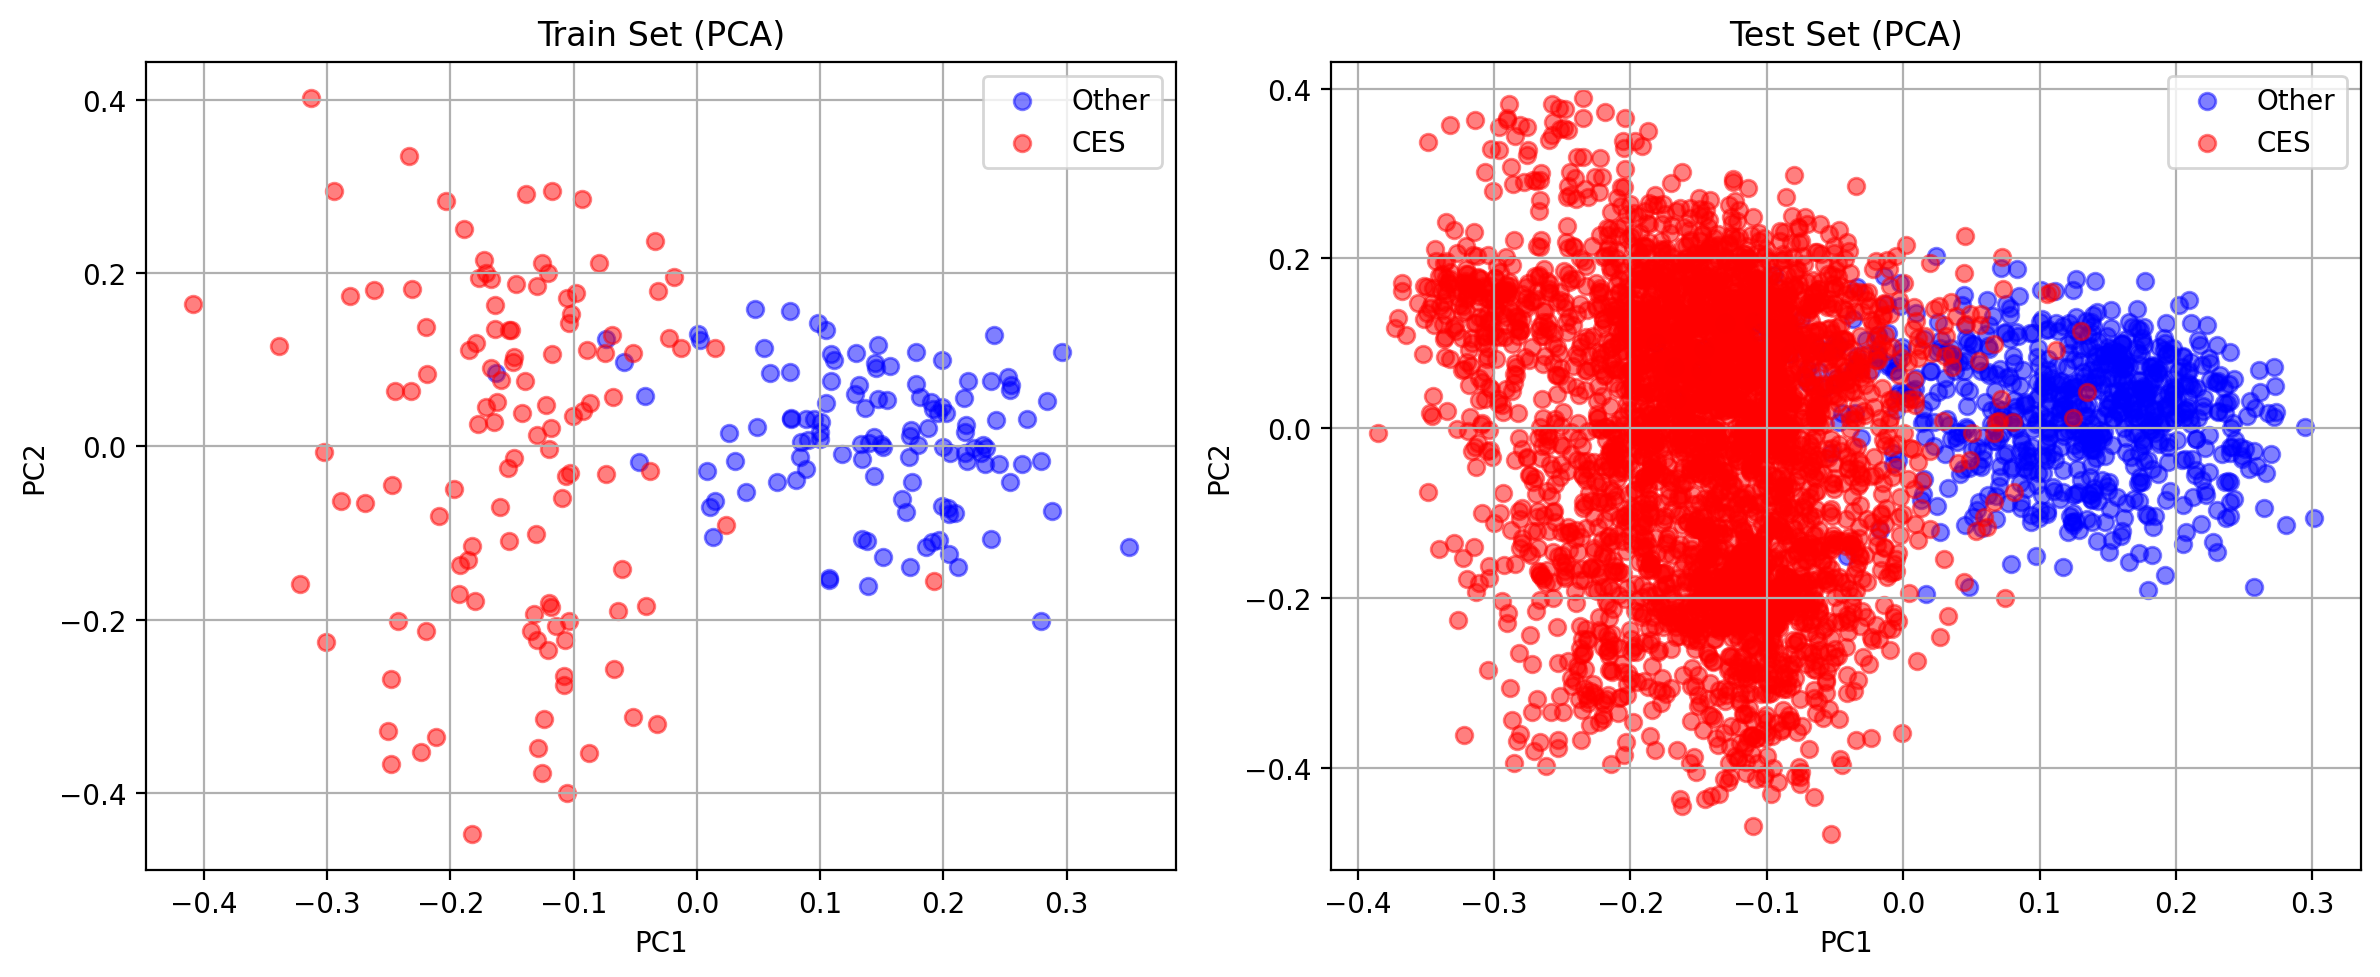

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Training set
axs[0].scatter(X_train_2d[y_train == 0, 0], X_train_2d[y_train == 0, 1], c='blue', label='Other', alpha=0.5)
axs[0].scatter(X_train_2d[y_train == 1, 0], X_train_2d[y_train == 1, 1], c='red', label='CES', alpha=0.5)
axs[0].set_title('Train Set (PCA)')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend()
axs[0].grid(True)

# Test set
axs[1].scatter(X_test_2d[y_test == 0, 0], X_test_2d[y_test == 0, 1], c='blue', label='Other', alpha=0.5)
axs[1].scatter(X_test_2d[y_test == 1, 0], X_test_2d[y_test == 1, 1], c='red', label='CES', alpha=0.5)
axs[1].set_title('Test Set (PCA)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


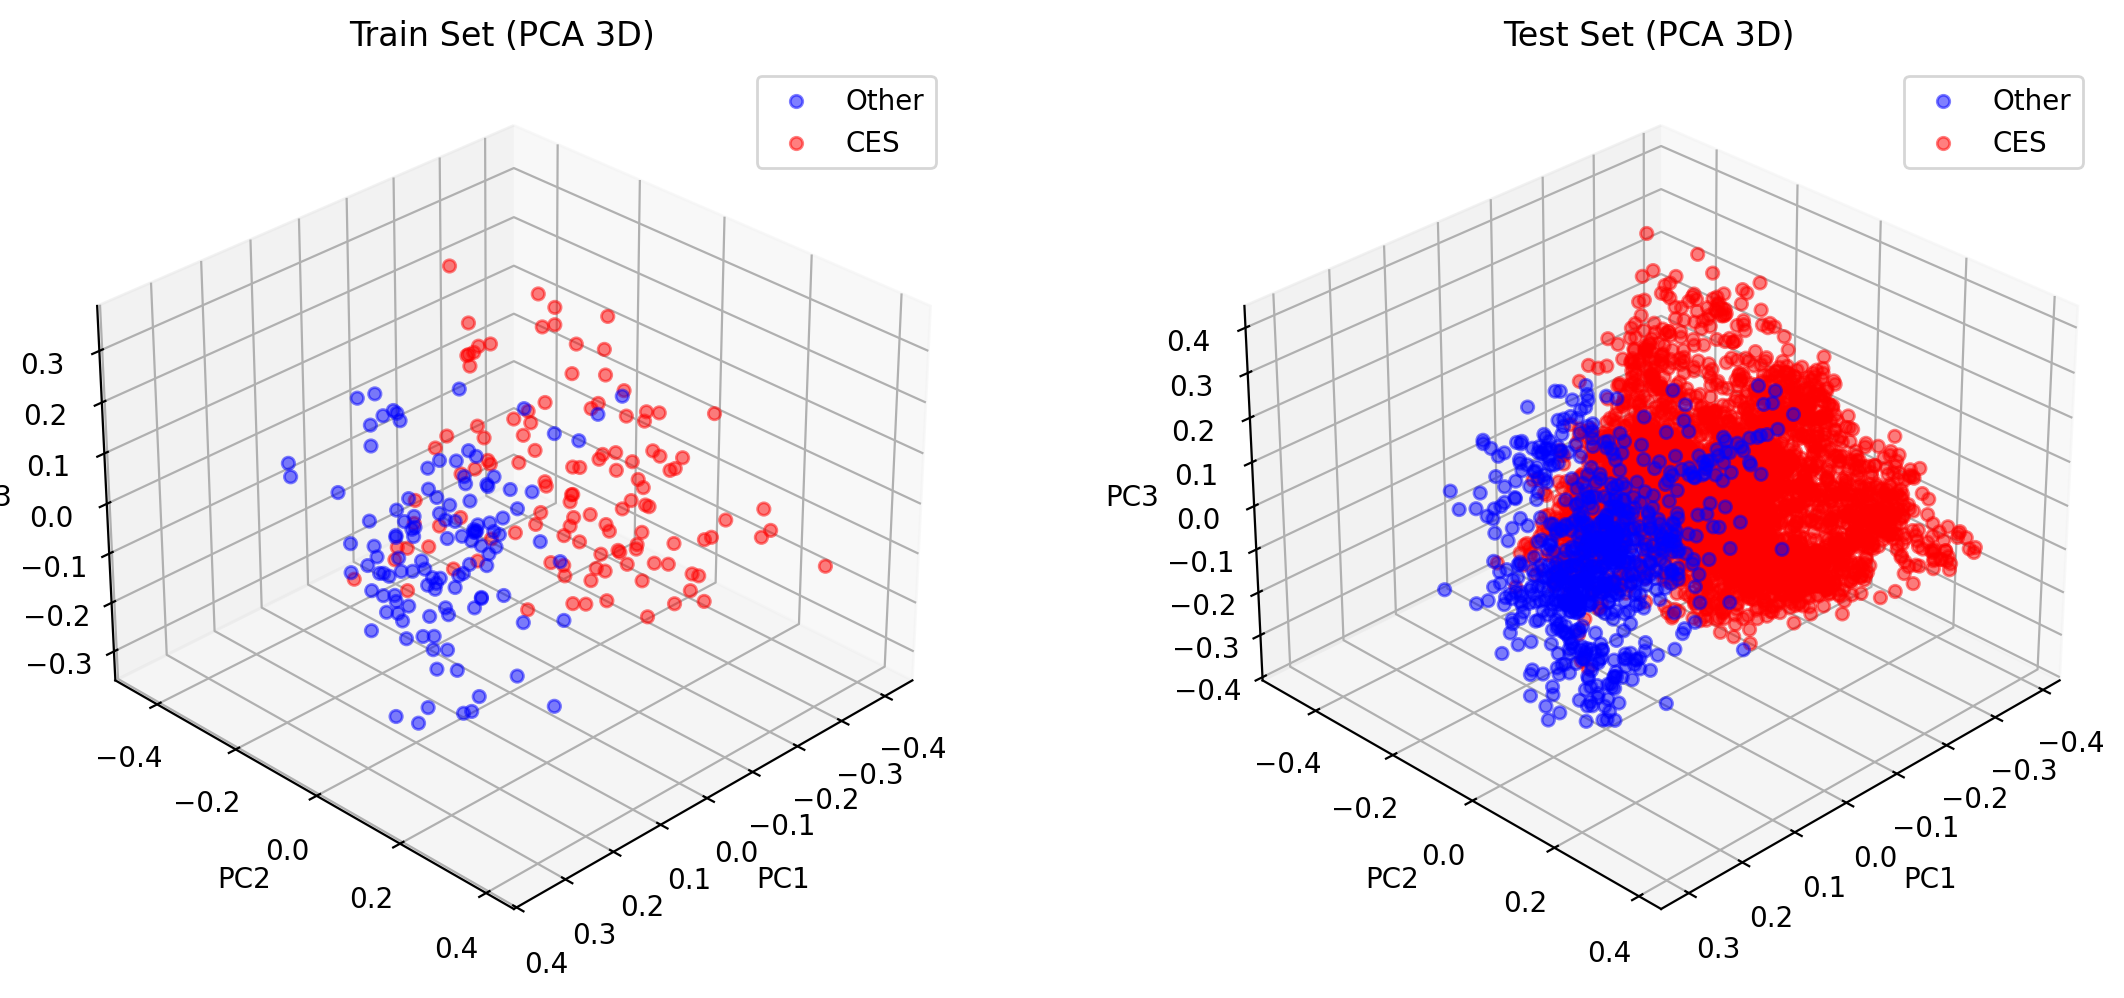

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using PCA
pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train)
X_test_3d = pca_3d.transform(X_test)

# 3D Plot for Train
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X_train_3d[y_train == 0, 0], X_train_3d[y_train == 0, 1], X_train_3d[y_train == 0, 2],
            c='blue', label='Other', alpha=0.5)
ax1.scatter(X_train_3d[y_train == 1, 0], X_train_3d[y_train == 1, 1], X_train_3d[y_train == 1, 2],
            c='red', label='CES', alpha=0.5)
ax1.set_title('Train Set (PCA 3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()

# 3D Plot for Test
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X_test_3d[y_test == 0, 0], X_test_3d[y_test == 0, 1], X_test_3d[y_test == 0, 2],
            c='blue', label='Other', alpha=0.5)
ax2.scatter(X_test_3d[y_test == 1, 0], X_test_3d[y_test == 1, 1], X_test_3d[y_test == 1, 2],
            c='red', label='CES', alpha=0.5)
ax2.set_title('Test Set (PCA 3D)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()

ax1.view_init(elev=30, azim=45)  # Train plot view
ax2.view_init(elev=30, azim=45) # Test plot view

plt.tight_layout()
plt.show()


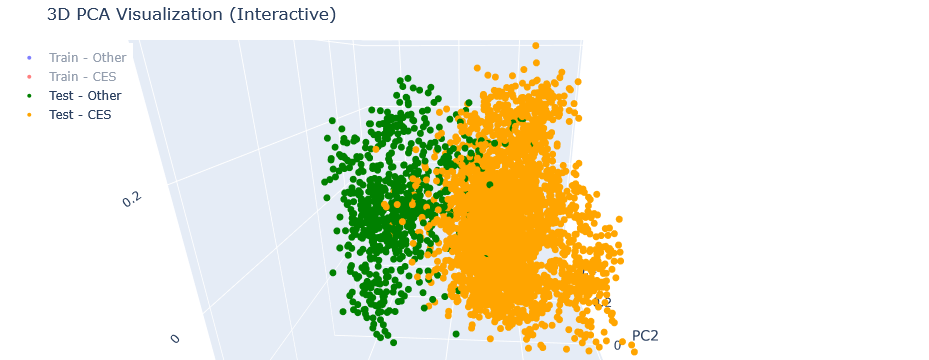

In [31]:
import plotly.graph_objs as go
import numpy as np
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=3)
X_train_3d = pca.fit_transform(X_train)
X_test_3d = pca.transform(X_test)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Helper function for hover text
def make_hover_text(ids, x_vals, y_vals, z_vals):
    return [
        f"ID: {id_}<br>x: {x:.6f}<br>y: {y:.6f}<br>z: {z:.6f}"
        for id_, x, y, z in zip(ids, x_vals, y_vals, z_vals)
    ]

# Train - Other
idx_other_train = y_train == 0
x_vals = X_train_3d[idx_other_train, 0]
y_vals = X_train_3d[idx_other_train, 1]
z_vals = X_train_3d[idx_other_train, 2]
ids = np.array(train_id)[idx_other_train]

trace_train_Other = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=4, color='blue'),
    text=make_hover_text(ids, x_vals, y_vals, z_vals),
    hoverinfo='text',
    name='Train - Other'
)

# Train - CES
idx_ces_train = y_train == 1
x_vals = X_train_3d[idx_ces_train, 0]
y_vals = X_train_3d[idx_ces_train, 1]
z_vals = X_train_3d[idx_ces_train, 2]
ids = np.array(train_id)[idx_ces_train]

trace_train_CES = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=4, color='red'),
    text=make_hover_text(ids, x_vals, y_vals, z_vals),
    hoverinfo='text',
    name='Train - CES'
)

# Test - Other
idx_other_test = y_test == 0
x_vals = X_test_3d[idx_other_test, 0]
y_vals = X_test_3d[idx_other_test, 1]
z_vals = X_test_3d[idx_other_test, 2]
ids = np.array(test_id)[idx_other_test]

trace_test_Other = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=4, color='green'),
    text=make_hover_text(ids, x_vals, y_vals, z_vals),
    hoverinfo='text',
    name='Test - Other'
)

# Test - CES
idx_ces_test = y_test == 1
x_vals = X_test_3d[idx_ces_test, 0]
y_vals = X_test_3d[idx_ces_test, 1]
z_vals = X_test_3d[idx_ces_test, 2]
ids = np.array(test_id)[idx_ces_test]

trace_test_CES = go.Scatter3d(
    x=x_vals,
    y=y_vals,
    z=z_vals,
    mode='markers',
    marker=dict(size=4, color='orange'),
    text=make_hover_text(ids, x_vals, y_vals, z_vals),
    hoverinfo='text',
    name='Test - CES'
)

# Layout
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(x=0.01, y=0.99),
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title='3D PCA Visualization (Interactive)'
)

# Plot
fig = go.Figure(data=[trace_train_Other, trace_train_CES, trace_test_Other, trace_test_CES], layout=layout)
fig.show()


## t-SNE

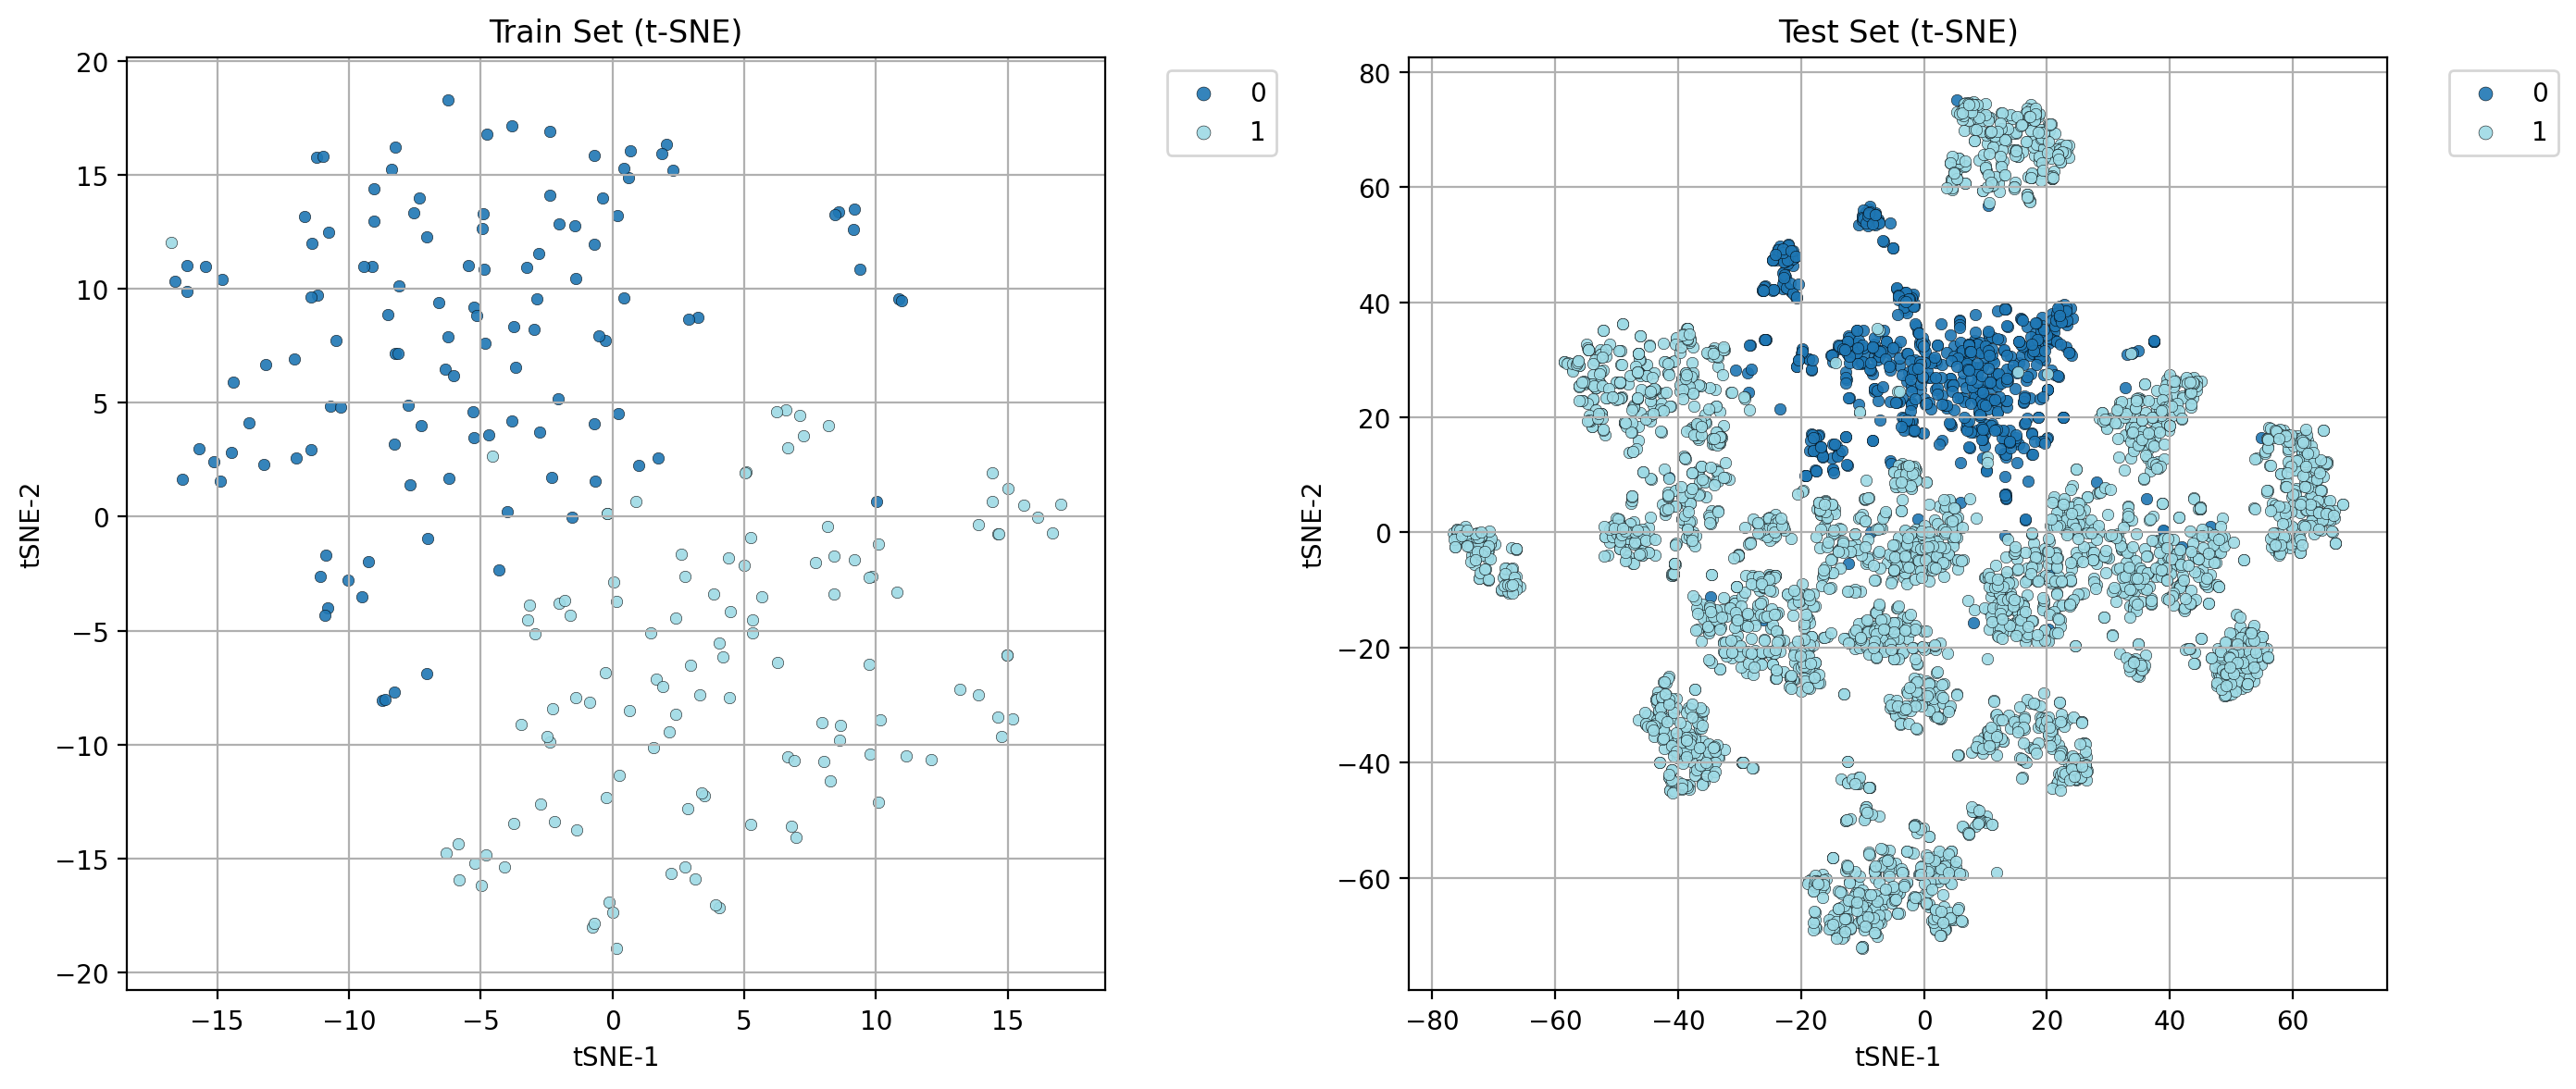

In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_train_2d = tsne.fit_transform(X_train)
X_test_2d = tsne.fit_transform(X_test)  # you can use separate t-SNE if test and train distributions differ

# Define colors for each label
colors = plt.cm.tab20(np.linspace(0, 1, 2))  # up to 20 distinct colors

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Train set
for i, label in enumerate([0,1]):
    marker_style = '^' if label == 'Other' else 'o'  # triangle if 'Other', else circle
    axs[0].scatter(X_train_2d[y_train == i, 0], X_train_2d[y_train == i, 1], 
                   label=label, alpha=0.9, s=20, color=colors[i], edgecolors='black', linewidth=0.2, marker=marker_style)
axs[0].set_title('Train Set (t-SNE)')
axs[0].set_xlabel('tSNE-1')
axs[0].set_ylabel('tSNE-2')
axs[0].legend(markerscale=1.2, bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True)

# Test set
for i, label in enumerate([0,1]):
    marker_style = '^' if label == 'Other' else 'o'
    axs[1].scatter(X_test_2d[y_test == i, 0], X_test_2d[y_test == i, 1], 
                   label=label, alpha=0.9, s=20, color=colors[i], edgecolors='black', linewidth=0.2, marker=marker_style)
axs[1].set_title('Test Set (t-SNE)')
axs[1].set_xlabel('tSNE-1')
axs[1].set_ylabel('tSNE-2')
axs[1].legend(markerscale=1.2, bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].grid(True)

plt.tight_layout()
plt.show()


# Confusion Matrix

In [ ]:
import numpy as np

In [ ]:
clip_pred_res = pd.read_excel('BestPrompt_Predictions.xlsx').reset_index(drop=True)
confusionMatrix(clip_pred_res, training_dataset, testing_dataset, class_names, savePath = f"{save_dir}/{'CLIP_Correct_Pred'}_results.csv")

In [ ]:
clip_pred_res = pd.read_excel('BestPrompt_Predictions.xlsx').reset_index(drop=True)
clip_pred_res['RF_Correct_Pred'] = clip_pred_res['Clip_Predictions']

In [34]:
# Step 1: Ensure 'id' is string type in all DataFrames
training_dataset['id'] = training_dataset['id'].astype(str)
testing_dataset['id'] = testing_dataset['id'].astype(str)
clip_pred_res['id'] = clip_pred_res['id'].astype(str)

# Step 2: Merge clip predictions into training and testing datasets
training_merged = training_dataset.merge(clip_pred_res[['id', 'Clip_Predictions']], on='id', how='left')
testing_merged = testing_dataset.merge(clip_pred_res[['id', 'Clip_Predictions']], on='id', how='left')



training_merged['RF_Correct_Pred'] = np.where(
    training_merged['Predict_binary'] == 'Other',
    'Other',
    training_merged['Clip_Predictions']
)

testing_merged['RF_Correct_Pred'] = np.where(
    testing_merged['Predict_binary'] == 'Other',
    'Other',
    testing_merged['Clip_Predictions']
)

# # Step 4: Optional — update original datasets if needed
# training_dataset = training_merged
# testing_dataset = testing_merged


In [35]:
DatasetsCom = {
        "trainingRes": training_merged, 
        "testingRes": testing_merged, 
    }

In [36]:
training_merged['label'].value_counts(), testing_merged['label'].value_counts()

(label
 Other                   120
 Boating                  10
 Camping                  10
 Fishing                  10
 Biking                   10
 Hiking                   10
 Horseback_Riding         10
 Landscape_Aesthetics     10
 Hunting                  10
 Shelling                 10
 Surfing                  10
 Swimming                 10
 Wildlife_Viewing         10
 Name: count, dtype: int64,
 label
 Other                   720
 Hiking                  478
 Swimming                425
 Landscape_Aesthetics    404
 Wildlife_Viewing        380
 Boating                 312
 Fishing                 251
 Horseback_Riding        248
 Camping                 234
 Surfing                 191
 Shelling                183
 Biking                  182
 Hunting                 177
 Name: count, dtype: int64)

In [37]:
combined = pd.concat([training_merged, testing_merged], ignore_index=True)
combined.to_csv(f'{save_dir}/RF_CLIP_Predict_res.csv', index=False)

In [38]:
nan_rows = testing_merged[testing_merged['RF_Correct_Pred'].isna()]
print(nan_rows)


Empty DataFrame
Columns: [Unnamed: 0, id, label, Phase, Binary_Label, Predict_binary, Clip_Predictions, RF_Correct_Pred]
Index: []


In [39]:
class_names = ["Biking", "Boating", "Camping", "Fishing", "Hiking", "Horseback_Riding", "Hunting", "Shelling", "Surfing", 
               "Swimming", "Wildlife_Viewing", "Landscape_Aesthetics", "Other"]

trainingRes
[[ 90.   0.   0.   0.  10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  90.   0.   0.   0.   0.   0.  10.   0.   0.   0.]
 [  0.   0.   0.   0.  80.   0.  10.   0.   0.   0.   0.  10.   0.]
 [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  90.   0.   0.  10.   0.   0.]
 [  0.  10.   0.   0.   0.   0.   0.   0.  80.   0.   0.  10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  10.  90.   0.   0.   0.]
 [  0.   0.   0.  10.   0.   0.   0.   0.   0.   0.  90.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]]


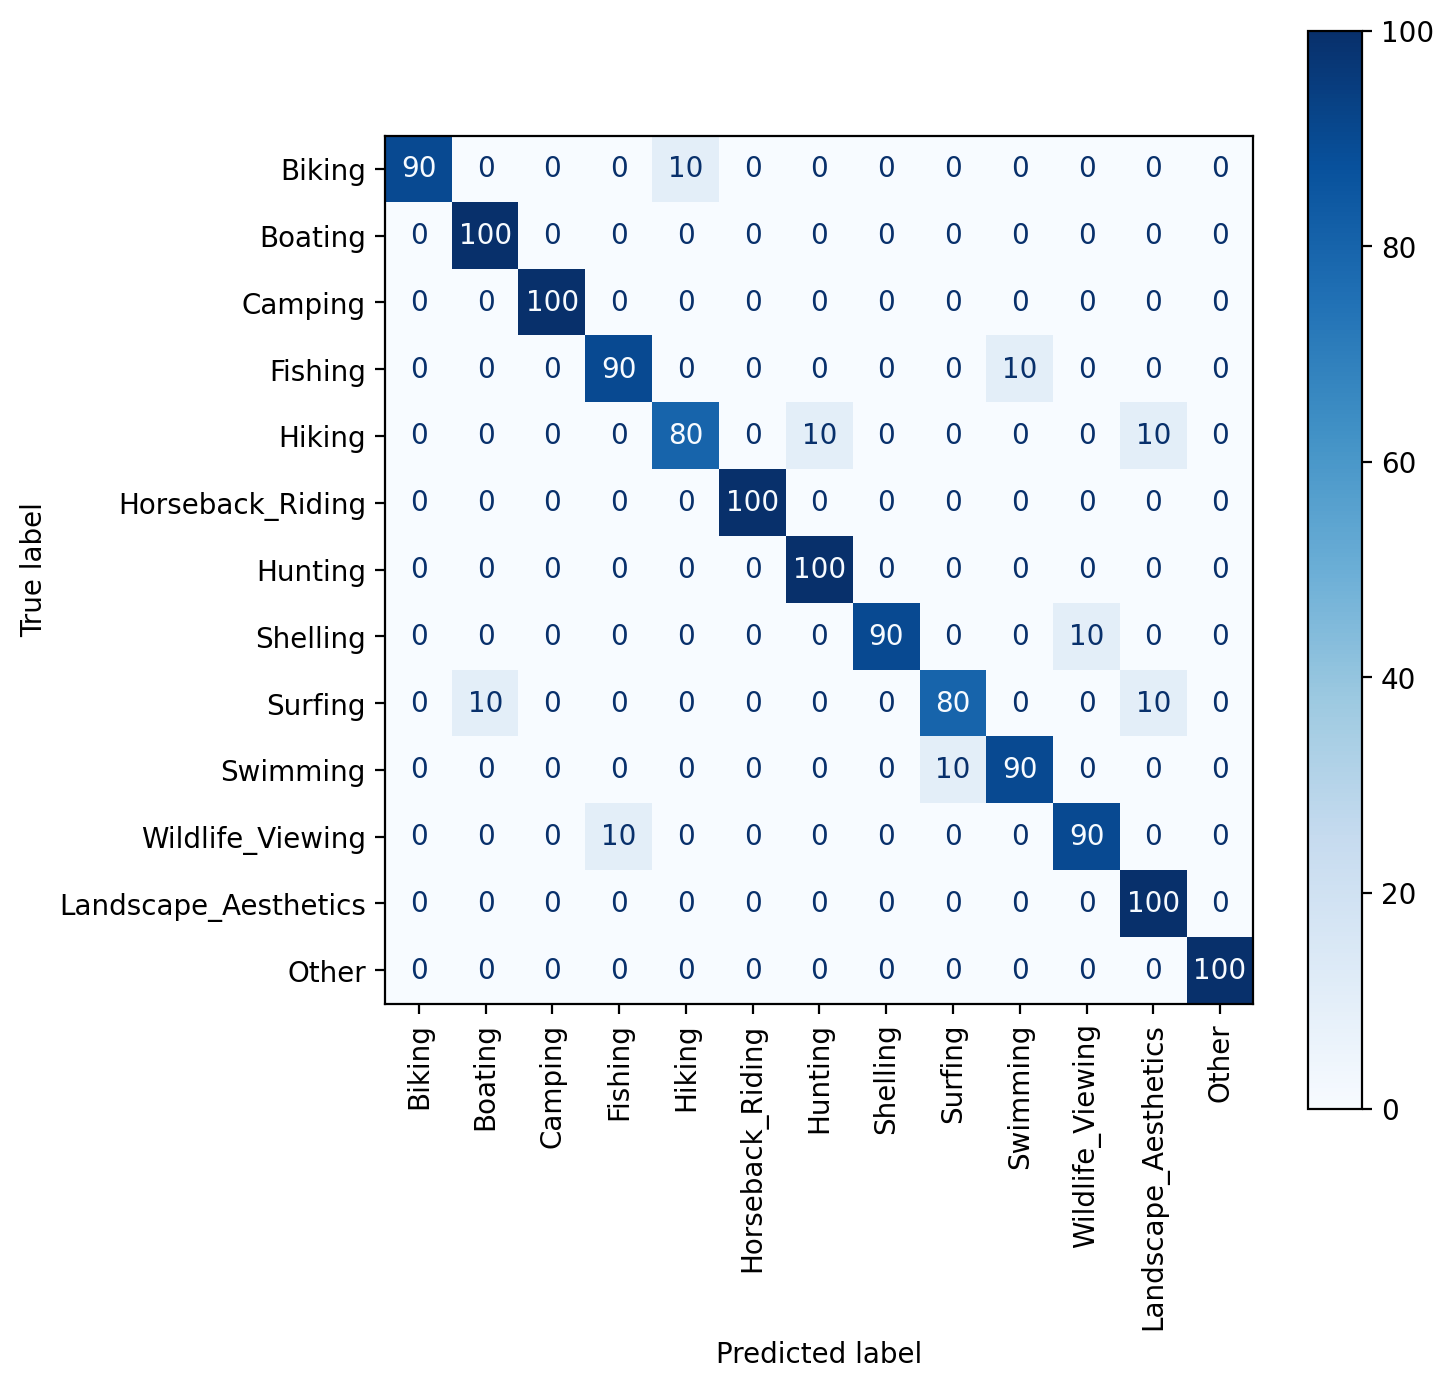

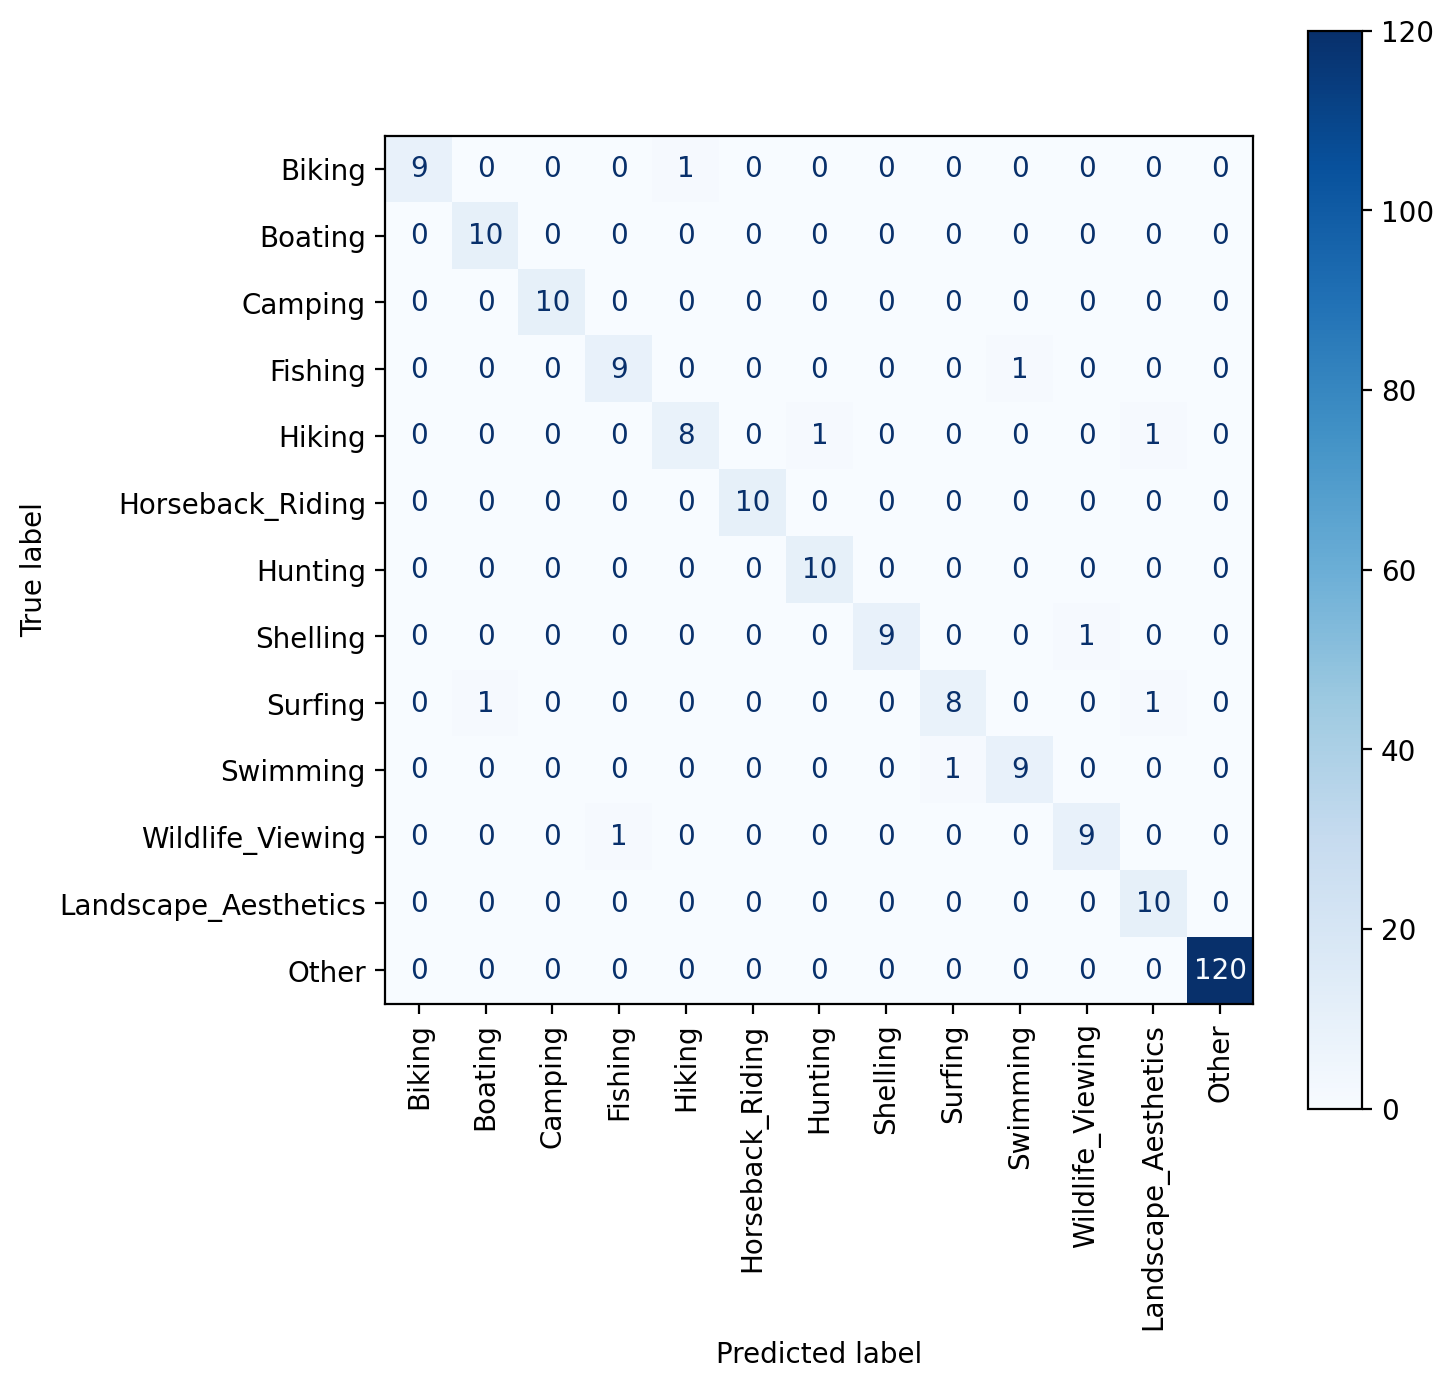

Accuracy: 96
Biking, Precision:100, Recall:90, F1:95
Boating, Precision:91, Recall:100, F1:95
Camping, Precision:100, Recall:100, F1:100
Fishing, Precision:90, Recall:90, F1:90
Hiking, Precision:89, Recall:80, F1:84
Horseback_Riding, Precision:100, Recall:100, F1:100
Hunting, Precision:91, Recall:100, F1:95
Shelling, Precision:100, Recall:90, F1:95
Surfing, Precision:89, Recall:80, F1:84
Swimming, Precision:90, Recall:90, F1:90
Wildlife_Viewing, Precision:90, Recall:90, F1:90
Landscape_Aesthetics, Precision:83, Recall:100, F1:91
Other, Precision:100, Recall:100, F1:100
Overall Acc:  96
Overall Precision:  93
Overall Recall:  93
Overall F1:  93
{'Biking': {'Description': 'Biking', 'Precision': 100, 'Recall': 90, 'F1-Score': 95}, 'Boating': {'Description': 'Boating', 'Precision': 91, 'Recall': 100, 'F1-Score': 95}, 'Camping': {'Description': 'Camping', 'Precision': 100, 'Recall': 100, 'F1-Score': 100}, 'Fishing': {'Description': 'Fishing', 'Precision': 90, 'Recall': 90, 'F1-Score': 90}, 

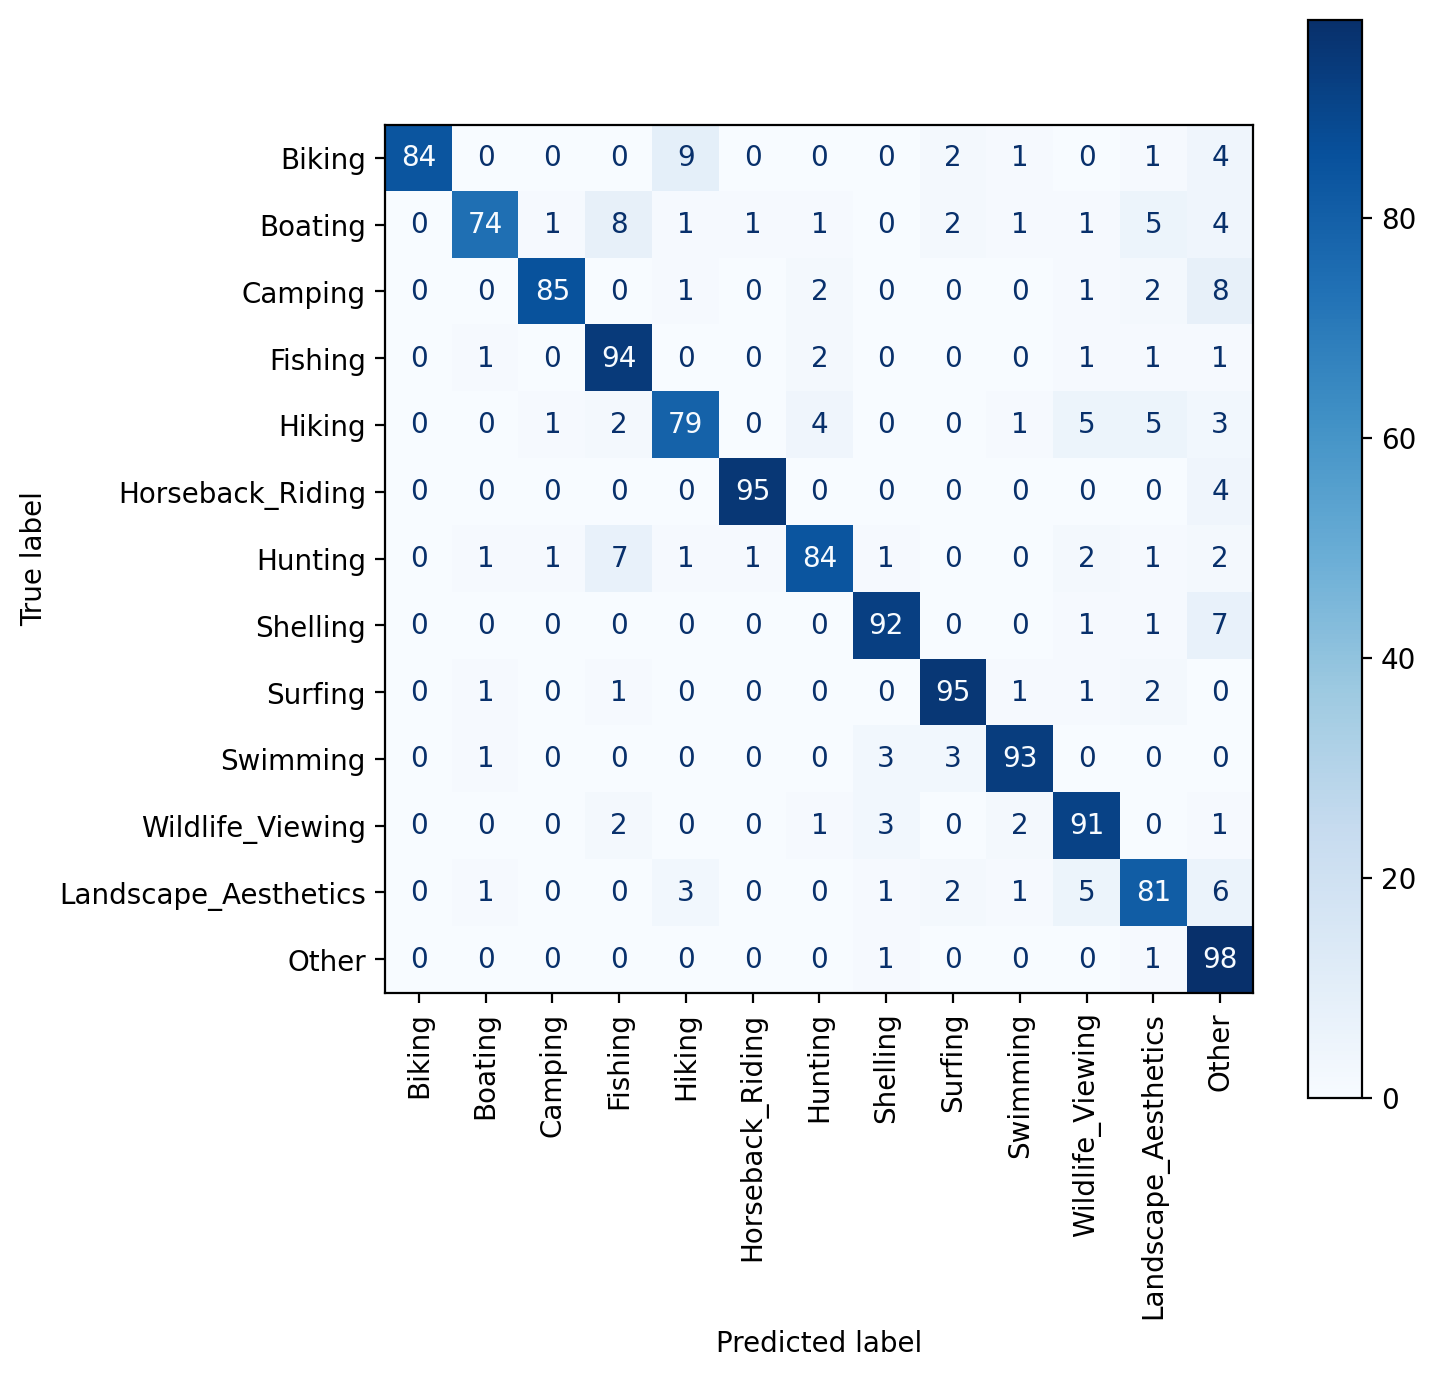

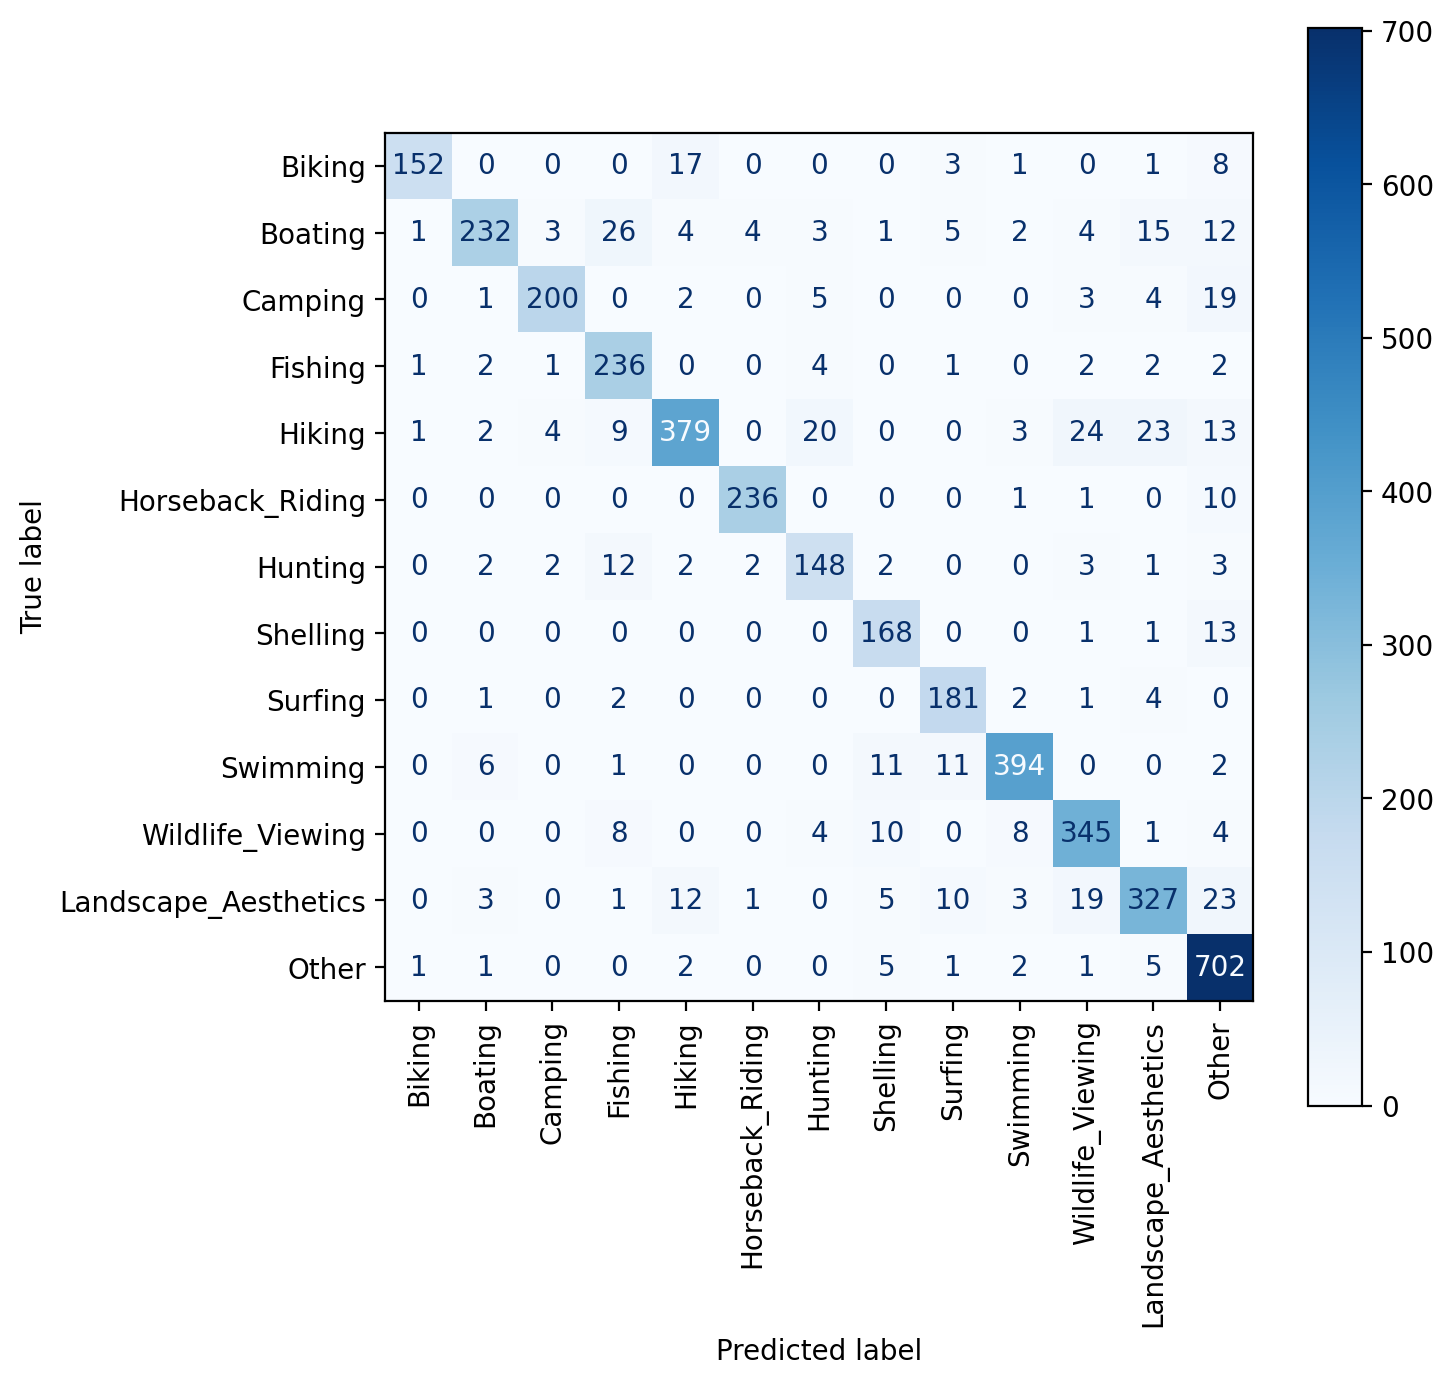

Accuracy: 88
Biking, Precision:97, Recall:84, F1:90
Boating, Precision:93, Recall:74, F1:83
Camping, Precision:95, Recall:85, F1:90
Fishing, Precision:80, Recall:94, F1:86
Hiking, Precision:91, Recall:79, F1:85
Horseback_Riding, Precision:97, Recall:95, F1:96
Hunting, Precision:80, Recall:84, F1:82
Shelling, Precision:83, Recall:92, F1:87
Surfing, Precision:85, Recall:95, F1:90
Swimming, Precision:95, Recall:93, F1:94
Wildlife_Viewing, Precision:85, Recall:91, F1:88
Landscape_Aesthetics, Precision:85, Recall:81, F1:83
Other, Precision:87, Recall:98, F1:92
Overall Acc:  88
Overall Precision:  89
Overall Recall:  88
Overall F1:  88
{'Biking': {'Description': 'Biking', 'Precision': 97, 'Recall': 84, 'F1-Score': 90}, 'Boating': {'Description': 'Boating', 'Precision': 93, 'Recall': 74, 'F1-Score': 83}, 'Camping': {'Description': 'Camping', 'Precision': 95, 'Recall': 85, 'F1-Score': 90}, 'Fishing': {'Description': 'Fishing', 'Precision': 80, 'Recall': 94, 'F1-Score': 86}, 'Hiking': {'Descrip

In [40]:
tmpA = pd.DataFrame()
for name, data in DatasetsCom.items():
    print(name)
    cm, accuracy = plotCom(data['label'], data['RF_Correct_Pred'], class_names, save_dir = save_dir, SaveName = f"{name}-{'RF_Correct_Pred'}")
    HashRes = classification_metrics(class_names, cm, class_names)
    tmpB = hash2pandas(HashRes, name)
    tmpA = pd.concat([tmpA, tmpB], ignore_index=True)
    print(HashRes,"\n")
    
tmpA.to_csv(f"{save_dir}/{'CLIP_Correct_Pred'}_results.csv", index=False)

In [79]:
testing_merged['label'].value_counts()

label
Other                   720
Hiking                  478
Swimming                425
Landscape_Aesthetics    404
Wildlife_Viewing        380
Boating                 312
Fishing                 251
Horseback_Riding        248
Camping                 234
Surfing                 191
Shelling                183
Biking                  182
Hunting                 177
Name: count, dtype: int64